### **Eyes RL SL**

In [18]:
#@title Cell 1: Imports and Data Loading
import json
import logging
import math
import pickle
import random
import time
from collections import deque

import numpy as np
import tensorflow as tf
from scipy.ndimage import zoom
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', force=False)

# Load MNIST data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize pixel values to be between 0 and 1
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

#@title Cell 2: Environment Class
class Environment:
    def __init__(self, images, labels):
        self.WINDOW_WIDTH = 4
        self.WINDOW_HEIGHT = 4
        self.MAX_MOVES = 20
        self.MAX_ZOOM_LEVEL = 7
        self.MIN_ZOOM_LEVEL = 1
        self.BASE_IMAGE_SIZE = 28  # Assuming MNIST images are 28x28
        self.images = images
        self.labels = labels
        self.pre_move_digit_probs = None
        self.reset()

    def reset(self):
        self.current_index = np.random.randint(0, len(self.images))
        self.current_image = self.images[self.current_index]
        self.image_label = self.labels[self.current_index]
        self.num_moves = 0
        self.zoom_level = 7  # Start with initial zoom
        self.window_position = (14, 14)  # Centered on a 28x28 image
        self.visited_positions = {}  # Track visited positions per zoom level
        return self.get_state()

    def apply_zoom(self):
        # Calculate the increment per zoom level step
        step_size = (28 - 4) / (self.MAX_ZOOM_LEVEL - self.MIN_ZOOM_LEVEL)  # 24 / 6 = 4 pixels per level

        # Calculate the current window size based on the zoom level
        window_size = 4 + int((self.zoom_level - 1) * step_size)

        return window_size

    def get_state(self):
        window_view = self.extract_window_view()
        state = np.concatenate([window_view.flatten(), [self.zoom_level, self.window_position[0] - 14, self.window_position[1] - 14]])
        return state

    def extract_window_view(self):
        window_size = self.apply_zoom()
        half_window = window_size // 2
        start_x = max(0, self.window_position[0] - half_window)
        end_x = min(self.BASE_IMAGE_SIZE, start_x + window_size)
        start_y = max(0, self.window_position[1] - half_window)
        end_y = min(self.BASE_IMAGE_SIZE, start_y + window_size)

        window_view = self.current_image[start_y:end_y, start_x:end_x]

        # Downsample to 4x4
        zoomed_view = zoom(window_view, (self.WINDOW_WIDTH / window_view.shape[0], self.WINDOW_HEIGHT / window_view.shape[1]), order=1)  # Using bilinear interpolation
        return zoomed_view

    def move_window(self, vertical_move, horizontal_move):
        window_size = self.apply_zoom()
        # Calculate the new position based on movement commands
        new_x = self.window_position[0] + horizontal_move
        new_y = self.window_position[1] + vertical_move

        # Calculate half the window size for boundary conditions
        half_window = window_size // 2

        # Ensure the window stays within the boundaries of the image
        new_x = max(half_window, min(new_x, self.BASE_IMAGE_SIZE - half_window))
        new_y = max(half_window, min(new_y, self.BASE_IMAGE_SIZE - half_window))

        # Update the window position
        self.window_position = (new_x, new_y)

    def step(self, action, agent, pre_move_digit_probs=None):
        logging.info(f"Pre-move state: {self.get_state()}")

        vertical_move, horizontal_move, zoom_action = action
        self.zoom_level = max(1, min(self.MAX_ZOOM_LEVEL, self.zoom_level * (2 ** zoom_action)))
        self.move_window(vertical_move, horizontal_move)

        state_copy = self.get_state()
        logging.info(f"Post-move state: {state_copy}")

        if self.pre_move_digit_probs is None:
            _, self.pre_move_digit_probs = agent.predict_digit(np.reshape(self.get_state(), [1, -1]))

        post_move_digit_probs = agent.predict_digit(np.reshape(self.get_state(), [1, -1]))[1]
        reward = self.calculate_reward(agent, self.pre_move_digit_probs, post_move_digit_probs)

        # Store post-move probabilities for next step
        self.pre_move_digit_probs = post_move_digit_probs

        self.num_moves += 1
        done = self.num_moves >= self.MAX_MOVES or action == agent.end_episode_action
        return state_copy, done, reward, post_move_digit_probs

    def calculate_reward(self, agent, pre_move_digit_probs, post_move_digit_probs):
        position_reward = self.calculate_position_reward()
        view_change_reward = self.calculate_view_change_reward()
        digit_prob_improvement = self.calculate_digit_prob_improvement(pre_move_digit_probs, post_move_digit_probs)

        reward = (position_reward * view_change_reward) + digit_prob_improvement
        _, post_move_digit_probs = agent.predict_digit(np.reshape(self.get_state(), [1, -1]))
        return reward, post_move_digit_probs

    def calculate_digit_prob_improvement(self, pre_move_digit_probs, post_move_digit_probs):

        pre_prob = pre_move_digit_probs[self.image_label]
        post_prob = post_move_digit_probs[self.image_label]

        # Calculate improvement (you can use the method suggested in the previous response)
        relative_improvement = (post_prob - pre_prob) / (pre_prob + 1e-8)
        normalized_improvement = 2 * (1 / (1 + math.exp(-10 * relative_improvement))) - 1

        return normalized_improvement

    def calculate_position_reward(self):
        x, y = self.window_position
        position_key = (x, y)
        if self.zoom_level not in self.visited_positions:
            self.visited_positions[self.zoom_level] = set()
        if position_key in self.visited_positions[self.zoom_level]:
            return 0  # No reward if already visited
        self.visited_positions[self.zoom_level].add(position_key)
        return 1  # Reward for new position

    def calculate_view_change_reward(self):
        current_view = self.get_state()[:16]  # Extract the relevant part of the state
        if not hasattr(self, 'previous_view'):
            self.previous_view = current_view
            return 0  # No reward for the first view

        view_change = np.sum(np.abs(current_view - self.previous_view))
        self.previous_view = current_view
        return view_change / 16.0  # Normalize the view change reward

    def get_current_label(self):
        return self.image_label

#@title Cell 3: DQNAgent Class
class LSTMAgent:
    def __init__(self, state_size, vertical_actions, horizontal_actions, zoom_actions, prediction_bonus=0.5, prediction_bonus_decay=0.999):
        self.state_size = state_size
        self.vertical_actions = vertical_actions
        self.horizontal_actions = horizontal_actions
        self.zoom_actions = zoom_actions
        self.num_actions = len(vertical_actions) * len(horizontal_actions) * len(zoom_actions)
        print(f"Total number of actions: {self.num_actions}")
        self.memory = deque(maxlen=8000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.end_episode_action = (0, 0, 0)
        self.prediction_bonus = prediction_bonus
        self.prediction_bonus_decay = prediction_bonus_decay
        self.model, self.target_model = self.build_models()
        logging.info("Models initialized successfully")
        self.update_target_network()

    def build_models(self):
        model = self._build_model()
        target_model = self._build_model()
        self.update_target_network()
        logging.info(model.summary())
        return model, target_model

    def _build_model(self):
        input_layer = layers.Input(shape=(None, self.state_size))
        lstm_1 = layers.LSTM(64, return_sequences=True)(input_layer)
        lstm_2 = layers.LSTM(64)(lstm_1)
        dense_1 = layers.Dense(64, activation='relu')(lstm_2)
        action_output = layers.Dense(self.num_actions, activation='linear', name='action_output')(dense_1)
        digit_output = layers.Dense(10, activation='softmax', name='digit_output')(dense_1)
        model = tf.keras.Model(inputs=input_layer, outputs=[action_output, digit_output], name='my_lstm_model')

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
            loss=[
                'mse',
                'sparse_categorical_crossentropy'
            ],
            loss_weights={
                'action_output': 0.9,
                'digit_output': 0.1
            }
        )

        return model

    def remember(self, state_sequence, action, reward, next_state_sequence, done, prediction_probs, predicted_digit, env):
        logging.info(f"Storing Experience - State sequence shape: {state_sequence.shape}, Action: {action}, Reward: {reward}, Next State sequence shape: {next_state_sequence.shape}, Done: {done}, Digit Label: {env.get_current_label()}")
        self.memory.append((state_sequence, action, reward, next_state_sequence, done, prediction_probs, predicted_digit, env.get_current_label()))

    def act(self, state_sequence):
        state_sequence = np.expand_dims(state_sequence, axis=0)  # Add batch dimension
        if np.random.rand() <= self.epsilon:
            action = (
                random.choice(self.vertical_actions),
                random.choice(self.horizontal_actions),
                random.choice(self.zoom_actions)
            )
        else:
            action_values, _ = self.model.predict(state_sequence)
            action_index = np.argmax(action_values[0])
            action = self.decode_action(action_index)

        _, digit_predictions = self.model.predict(state_sequence)
        digit_probs = tf.nn.softmax(digit_predictions).numpy()

        return action, digit_probs[0]

    def decode_action(self, index):
        v_index = index // (len(self.horizontal_actions) * len(self.zoom_actions))
        h_index = (index % (len(self.horizontal_actions) * len(self.zoom_actions))) // len(self.zoom_actions)
        z_index = index % len(self.zoom_actions)

        return (
            self.vertical_actions[v_index],
            self.horizontal_actions[h_index],
            self.zoom_actions[z_index]
        )


    def replay(self, batch_size, env):
        if len(self.memory) < batch_size:
            logging.info("Not enough samples in memory to replay.")
            return

        minibatch = random.sample(self.memory, batch_size)
        state_sequences = np.array([experience[0] for experience in minibatch])
        actions = np.array([self._get_action_index(experience[1]) for experience in minibatch])
        rewards = np.array([experience[2] for experience in minibatch])
        next_state_sequences = np.array([experience[3] for experience in minibatch])
        dones = np.array([experience[4] for experience in minibatch])
        digit_targets = np.array([int(experience[7]) for experience in minibatch])

        with tf.GradientTape() as tape:
            current_q_values, current_digit_probs = self.model(state_sequences)
            next_q_values, _ = self.target_model(next_state_sequences)

            target_q_values = current_q_values.numpy()
            for i in range(batch_size):
                if dones[i]:
                    target_q_values[i, actions[i]] = rewards[i]
                else:
                    target_q_values[i, actions[i]] = rewards[i] + self.gamma * np.max(next_q_values[i])
            target_q_values = tf.convert_to_tensor(target_q_values)

            action_loss = tf.keras.losses.mean_squared_error(target_q_values, current_q_values)
            digit_loss = tf.keras.losses.sparse_categorical_crossentropy(digit_targets, current_digit_probs)

            total_loss = action_loss + digit_loss  # Adjust the weight of digit loss if needed

        gradients = tape.gradient(total_loss, self.model.trainable_variables)
        self.model.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

        logging.info(f"Replay batch - State sequences shape: {state_sequences.shape}, Target Q-values shape: {target_q_values.shape}, Digit targets shape: {digit_targets.shape}")
        logging.info(f"Action Loss: {action_loss.numpy()}, Digit Loss: {digit_loss.numpy()}, Total Loss: {total_loss.numpy()}")

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return total_loss

    def _get_action_index(self, action):
        v, h, z = action
        return (
            self.vertical_actions.index(v) * len(self.horizontal_actions) * len(self.zoom_actions) +
            self.horizontal_actions.index(h) * len(self.zoom_actions) +
            self.zoom_actions.index(z)
        )

    def predict_digit(self, state_sequence):
        state_sequence = np.expand_dims(state_sequence, axis=0)  # Add batch dimension
        raw_predictions = self.model.predict(state_sequence)
        logging.info(f"Raw model output: {raw_predictions}")

        _, digit_predictions = raw_predictions
        digit_probs = tf.nn.softmax(digit_predictions).numpy()
        logging.info(f"Softmax probabilities: {digit_probs[0]}")

        return np.argmax(digit_probs[0]), digit_probs[0]

    def update_target_network(self):
        if hasattr(self, 'target_model') and hasattr(self, 'model'):
            self.target_model.set_weights(self.model.get_weights())
            logging.info("Target network updated.")
        else:
            logging.error("Model or target model is not initialized.")

    def save_memory(self, filename="agent_memory.pkl"):
        try:
            with open(filename, "wb") as f:
                pickle.dump(self.memory, f)
            logging.info(f"Memory saved to '{filename}'.")
        except Exception as e:
            logging.error(f"Failed to save memory: {str(e)}")

    def load_memory(self, filename="agent_memory.pkl"):
        try:
            with open(filename, "rb") as f:
                self.memory = pickle.load(f)
            logging.info(f"Memory loaded from '{filename}'. Resuming training.")
        except FileNotFoundError:
            logging.warning(f"Memory file '{filename}' not found. Starting with an empty memory.")
        except Exception as e:
            logging.error(f"An error occurred while loading memory: {str(e)}")

#@title Cell 4: Main Training Function
def setup_logging():
    # Create logger
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)  # Set the logging level

    # Create a file handler that logs even debug messages
    fh = logging.FileHandler('training_log.log')
    fh.setLevel(logging.INFO)  # Set level to info to match the console output

    # Create console handler with a higher log level
    ch = logging.StreamHandler()
    ch.setLevel(logging.INFO)

    # Create formatter and add it to the handlers
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    fh.setFormatter(formatter)
    ch.setFormatter(formatter)

    # Add the handlers to logger
    logger.addHandler(fh)
    logger.addHandler(ch)

def main():
    env = Environment(train_images, train_labels)
    initial_state = env.reset()
    state_size = len(initial_state)
    agent = LSTMAgent(state_size, [-1, 0, 1], [-1, 0, 1], [-1, 0, 1])
    logging.info("LSTMAgent created successfully")

    episodes = 500 # or any number of episodes you plan to run
    update_target_every = 50
    batch_size = 1000 # Define your desired batch size

    # File paths
    memory_filename = "agent_memory.pkl"
    model_weights_filename = "lstm_model_weights.h5"
    training_data_filename = "training_data.json"

    # Load Memory and Model Weights (if available)
    agent.load_memory(memory_filename)

    if tf.io.gfile.exists(model_weights_filename):
        agent.model = tf.keras.models.load_model(model_weights_filename)
        agent.target_model = tf.keras.models.load_model(model_weights_filename)
    else:
        logging.info("Model weights file not found. Starting with a new model.")

    training_data = []
    for e in range(episodes):
        episode_start_time = time.time()
        state, total_reward, predicted_digit, episode_data = run_episode(env, agent, state_size, e)
        training_data.append(episode_data)
        update_training(agent, e, update_target_every, batch_size, env)

        logging.info(f"Episode {e + 1}: Total Reward: {total_reward}")

    # Save training data and model weights
    save_training_data(agent, training_data_filename, memory_filename, model_weights_filename, training_data)

def run_episode(env, agent, state_size, episode_number, sequence_length=5):
    episode_states = []
    episode_actions = []
    episode_rewards = []
    episode_window_positions = []
    episode_prediction_probs = []
    episode_true_labels = []

    state = np.reshape(env.reset(), [1, state_size])
    state_sequence = np.zeros((sequence_length, state_size))
    for i in range(sequence_length):
        state_sequence[i] = state

    total_reward = 0
    done = False

    while not done:
        action, prediction_probs = agent.act(state_sequence)
        predicted_digit = np.argmax(prediction_probs)
        next_state, done, reward_tuple, post_move_digit_probs = env.step(action, agent)

        reward, _ = reward_tuple

        if len(episode_prediction_probs) > 0:
            pre_move_probs = episode_prediction_probs[-1]
        else:
            pre_move_probs = prediction_probs

        next_state = np.reshape(next_state, [1, state_size])
        next_state_sequence = np.roll(state_sequence, -1, axis=0)
        next_state_sequence[-1] = next_state

        agent.remember(state_sequence, action, reward, next_state_sequence, done, pre_move_probs, post_move_digit_probs, env)

        episode_states.append(state.flatten().tolist())
        episode_actions.append(action)
        episode_rewards.append(reward)
        episode_prediction_probs.append(post_move_digit_probs.tolist())
        episode_true_labels.append(int(env.get_current_label()))

        state_sequence = next_state_sequence
        state = next_state
        total_reward += reward

    if predicted_digit != env.get_current_label():
        reward_adjustment = -total_reward
        total_reward += reward_adjustment
        episode_rewards[-1] += reward_adjustment

    states = np.array(episode_states)
    true_labels = np.array(episode_true_labels)

    # Reshape states to match the LSTM input shape
    states_reshaped = np.expand_dims(states, axis=0)

    # Ensure that the number of labels matches the number of time steps in the input
    true_labels_reshaped = np.expand_dims(true_labels[-1], axis=0)  # Use only the last label

    _, digit_predictions = agent.model.predict(states_reshaped)

    # Fit the model using only the last state and label
    digit_loss = agent.model.fit(states_reshaped[:, -1:, :], true_labels_reshaped, epochs=1, verbose=0)
    logging.info(f"Episode {episode_number} Digit Loss: {digit_loss.history['loss'][0]}")

    return state_sequence, total_reward, predicted_digit, {
        'episode': episode_number,
        'image_id': int(env.current_index),
        'total_reward': total_reward,
        'accuracy': total_reward / env.MAX_MOVES if total_reward > 0 else 0,
        'predicted_digit': int(predicted_digit),
        'true_label': int(env.get_current_label()),
        'states': episode_states,
        'rewards': episode_rewards,
        'actions': episode_actions,
        'prediction_probs': episode_prediction_probs
    }

def update_training(agent, episode_number, update_target_every, batch_size, env):  # Add env as argument
    if (episode_number + 1) % update_target_every == 0:
        agent.update_target_network()

    agent.replay(batch_size, env)  # Now you can use batch_size

def log_training_summary(start_time, episodes, episode_times):
    total_time = time.time() - start_time
    avg_time_per_episode = np.mean(episode_times)
    logging.info(f"Training completed in {total_time:.2f}s over {episodes} episodes. Average time per episode: {avg_time_per_episode:.2f}s")

def save_training_data(agent, training_data_filename, memory_filename, model_weights_filename, training_data):
    # Save the memory of the agent
    agent.save_memory(memory_filename)
    # Save the model weights
    agent.model.save(model_weights_filename)

    # Save the training data to a JSON file
    with open(training_data_filename, 'w') as f:
        json.dump(training_data, f, indent=4)
    logging.info(f"Training data saved to '{training_data_filename}'.")

if __name__ == '__main__':
    main()

Total number of actions: 27


ERROR:root:Model or target model is not initialized.


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 44ms/step


In [20]:
#@title Accuracy Training
import json

def calculate_accuracy_from_json(file_path):
    with open(file_path, 'r') as f:
        test_data = json.load(f)

    total_episodes = len(test_data)
    correct_predictions = sum(episode['accuracy'] for episode in test_data)

    accuracy = correct_predictions / total_episodes

    print(f"Total episodes: {total_episodes}")
    print(f"Correct predictions: {correct_predictions}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Accuracy percentage: {accuracy * 100:.2f}%")

    return accuracy

# Usage
file_path = 'training_data.json'
accuracy = calculate_accuracy_from_json(file_path)

Total episodes: 500
Correct predictions: 67.67906664645348
Accuracy: 0.1354
Accuracy percentage: 13.54%


In [19]:
#@title Save and Download as Zip
import pickle
import zipfile
from google.colab import files

# --- Define Filenames (with paths) ---
memory_filename = "/content/agent_memory.pkl"
model_weights_filename = "/content/lstm_model_weights.h5"
training_data_filename = "/content/training_data.json"
zip_filename = "/content/training_results.zip"

# --- Create and Populate Zip File ---
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    zipf.write(memory_filename)
    zipf.write(model_weights_filename)
    zipf.write(training_data_filename)

print(f"Training results zipped to '{zip_filename}'.")

# --- Download the Zip File ---
files.download(zip_filename)

Training results zipped to '/content/training_results.zip'.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Enter the starting episode number: 295
Enter the ending episode number: 299


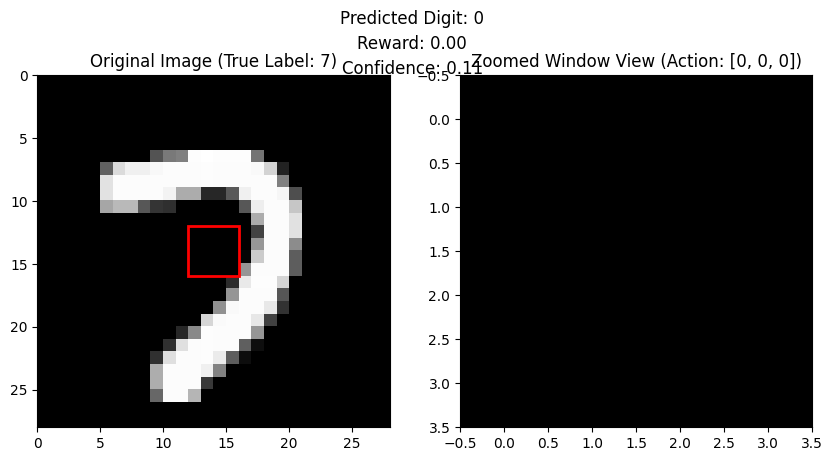

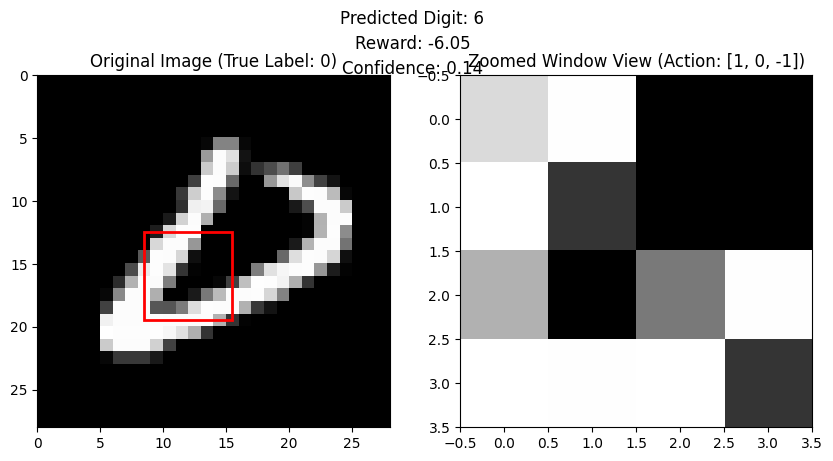

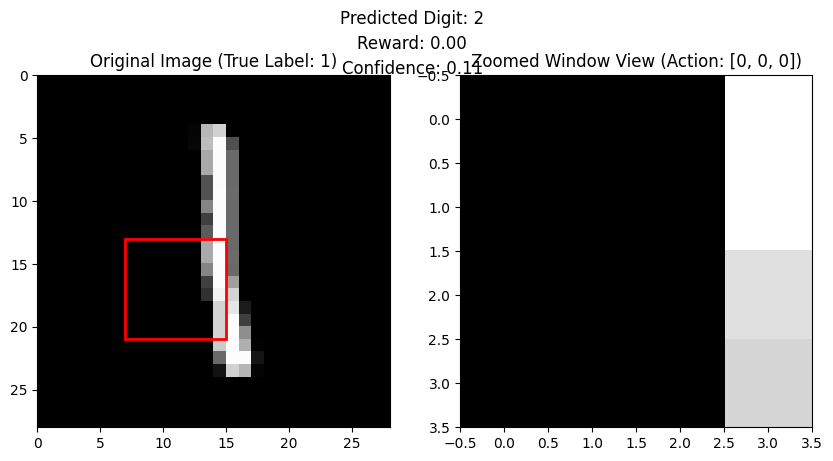

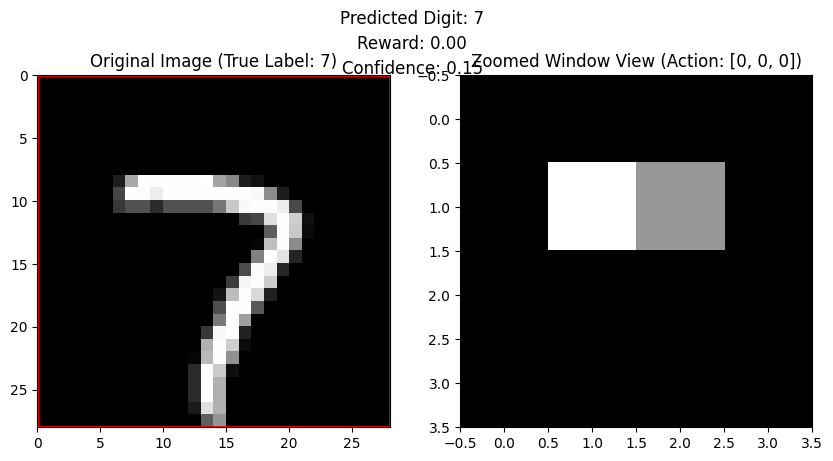

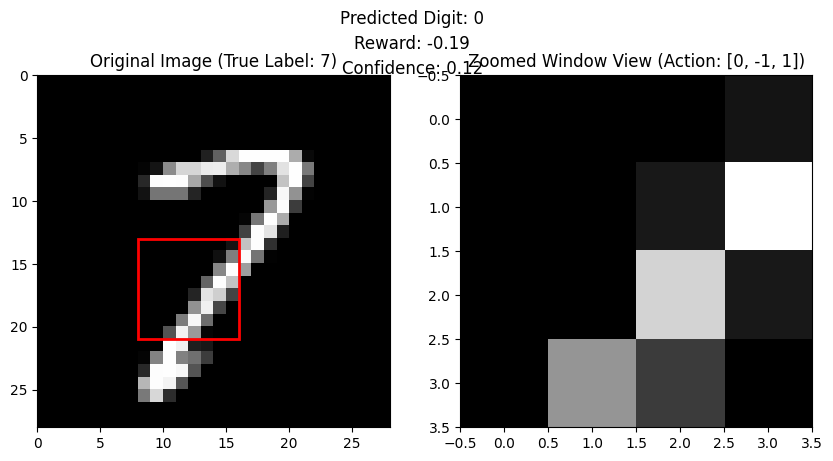

In [5]:
#@title Visualzier for training
import json
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from tensorflow.keras.datasets import mnist
from matplotlib.animation import FFMpegWriter

def visualize_episode(episode_data, train_images):
    image_id = episode_data['image_id']
    states = episode_data['states']
    actions = episode_data['actions']
    true_label = episode_data['true_label']
    total_rewards = episode_data['total_reward']
    accuracies = episode_data['accuracy']
    rewards = episode_data['rewards']  # Get rewards for each step
    prediction_probs = episode_data['prediction_probs'] # Get prediction probabilities

    image = train_images[image_id] / 255.0

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(image, cmap='gray', extent=[0, 28, 28, 0])
    ax1.set_title(f"Original Image (True Label: {true_label})")
    ax2.set_title("Zoomed Window View")
    # Add text objects for dynamic information
    text_predicted = fig.text(0.5, 0.95, '', ha='center', fontsize=12)
    text_reward = fig.text(0.5, 0.9, '', ha='center', fontsize=12)
    text_prob = fig.text(0.5, 0.85, '', ha='center', fontsize=12)

    def animate(i):
        state = states[i]
        window_view = np.array(state[:16]).reshape((4, 4))
        action = actions[i]
        zoom_level = state[16]  # Assuming zoom level is stored at index 16 in the state array
        reward = rewards[i]  # Get reward for the current step
        probs = prediction_probs[i] # Get probabilities list

        ax2.cla()
        ax2.imshow(window_view, cmap='gray', interpolation='nearest')
        ax2.set_title(f"Zoomed Window View (Action: {action})")

        # DETERMINE THE PREDICTED DIGIT FOR THIS STEP:
        step_predicted_digit = np.argmax(probs)

        # Access the predicted probability for THIS STEP:
        predicted_prob = probs[step_predicted_digit]

        # Clear all patches (previous rectangles) from ax1
        for patch in reversed(ax1.patches):
            patch.remove()

        # Calculate the rectangle dimensions based on the zoom level
        rect_width = rect_height = 4 * zoom_level  # Adjust the size based on the zoom level

        # Calculate the position of the rectangle
        x_pos = (state[-2])+14 - rect_width / 2  # Corrected calculation
        y_pos = (state[-1])+14 - rect_height / 2  # Corrected calculation

        # Draw the rectangle on ax1
        rect = plt.Rectangle((x_pos, y_pos), rect_width, rect_height, linewidth=2, edgecolor='r', facecolor='none')
        ax1.add_patch(rect)

        # Update the text objects with current information
        text_predicted.set_text(f"Predicted Digit: {step_predicted_digit}") # Use step_predicted_digit
        text_reward.set_text(f"Reward: {reward:.2f}")
        text_prob.set_text(f"Confidence: {predicted_prob:.2f}")

        return []

    ani = animation.FuncAnimation(fig, animate, frames=len(states), interval=50, blit=False, repeat=False)
    writer = FFMpegWriter(fps=10, metadata=dict(artist='Me'), bitrate=1800)
    ani.save(f"episode_{episode_data['episode']}_visualization.mp4", writer=writer)
    plt.show()

def main():
    (train_images, train_labels), (_, _) = mnist.load_data()
    with open('training_data.json', 'r') as jsonfile:
        training_data = json.load(jsonfile)

    start_episode = int(input("Enter the starting episode number: "))
    end_episode = int(input("Enter the ending episode number: "))

    if start_episode < 0 or end_episode >= len(training_data) or start_episode > end_episode:
        print(f"Invalid episode range. Please choose a valid range between 0 and {len(training_data)-1}.")
    else:
        for episode_to_visualize in range(start_episode, end_episode + 1):
            visualize_episode(training_data[episode_to_visualize], train_images)

if __name__ == "__main__":
    main()


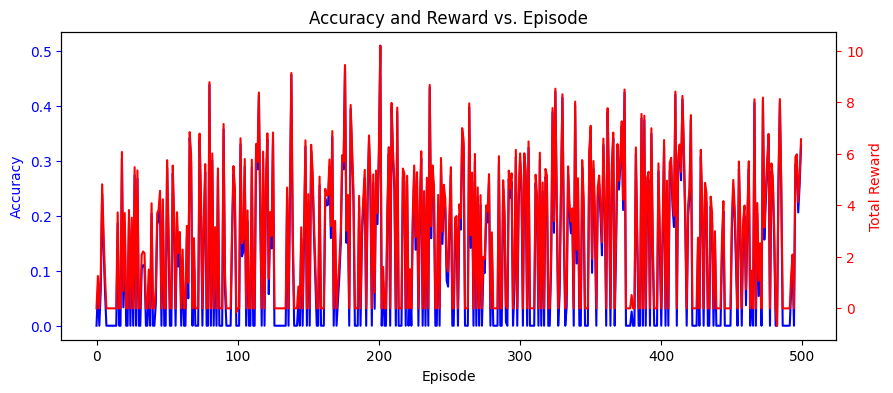

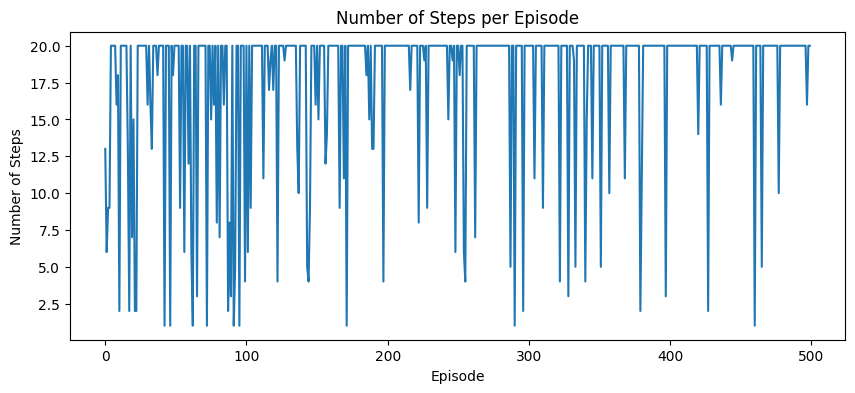

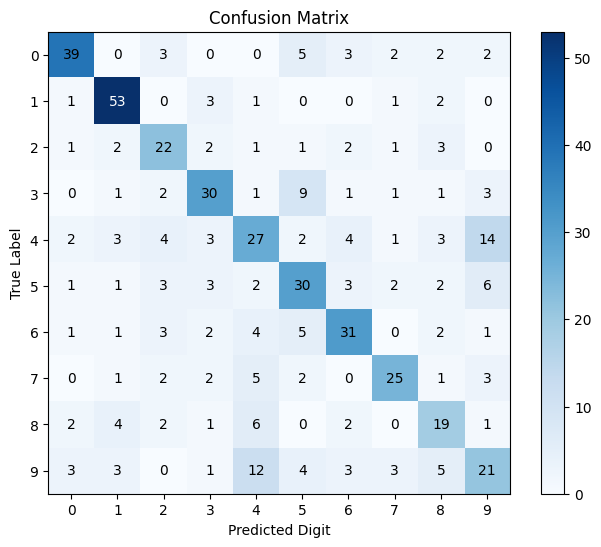

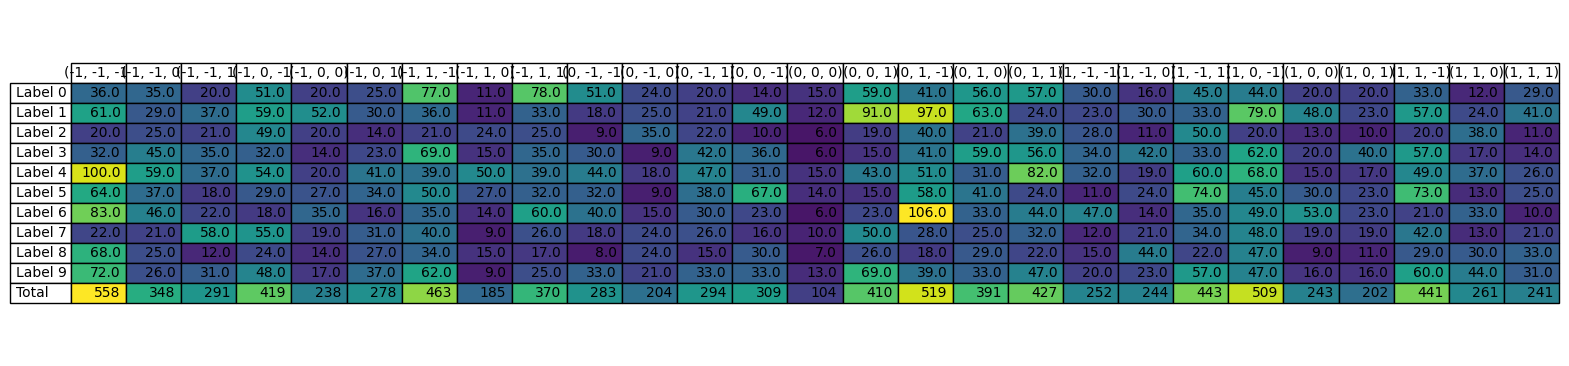

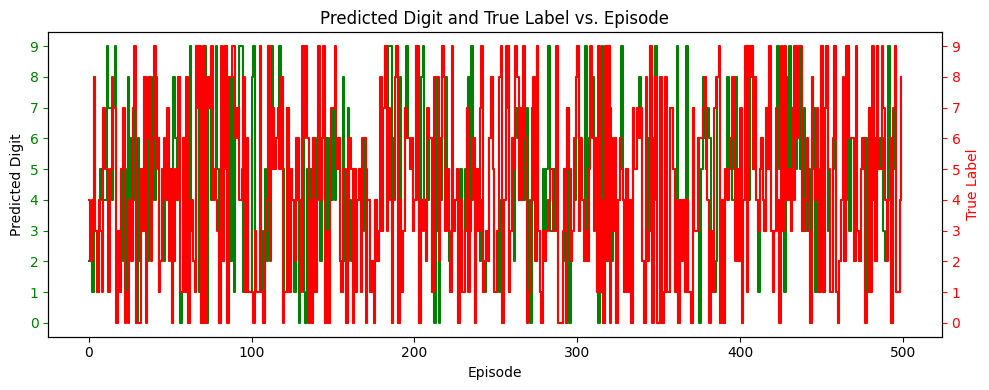

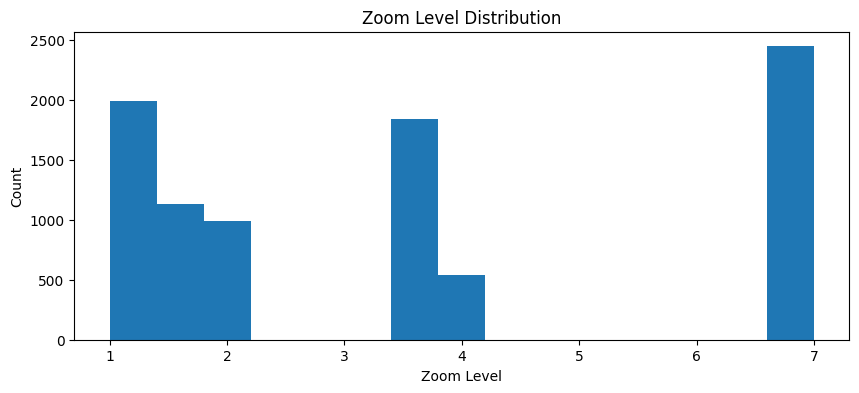

In [25]:
#@title Charts
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import itertools

# --- Load the training data ---
with open('training_data.json', 'r') as f:
    training_data = json.load(f)

# --- Extract data ---
episode_numbers = [data['episode'] for data in training_data]
accuracies = [data['accuracy'] for data in training_data]
rewards = [data['total_reward'] for data in training_data]
predicted_digits = [data['predicted_digit'] for data in training_data]
true_labels = [data['true_label'] for data in training_data]
steps_per_episode = [len(data['actions']) for data in training_data]
zoom_levels = [state[16] for data in training_data for state in data['states']] # Extract zoom levels

# --- Visualization 1: Accuracy and Reward vs. Episode ---
fig, ax1 = plt.subplots(figsize=(10, 4))
ax2 = ax1.twinx()

ax1.plot(episode_numbers, accuracies, 'b-', label='Accuracy')
ax2.plot(episode_numbers, rewards, 'r-', label='Reward')

ax1.set_xlabel('Episode')
ax1.set_ylabel('Accuracy', color='b')
ax2.set_ylabel('Total Reward', color='r')
ax1.tick_params('y', colors='b')
ax2.tick_params('y', colors='r')

plt.title('Accuracy and Reward vs. Episode')
plt.show()

# --- Visualization 4: Steps per Episode ---
plt.figure(figsize=(10, 4))
plt.plot(episode_numbers, steps_per_episode)
plt.xlabel('Episode')
plt.ylabel('Number of Steps')
plt.title('Number of Steps per Episode')
plt.show()

# --- Visualization 2: Confusion Matrix ---
confusion_matrix = np.zeros((10, 10), dtype=int)
for t, p in zip(true_labels, predicted_digits):
    confusion_matrix[t, p] += 1

plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.xlabel('Predicted Digit')
plt.ylabel('True Label')

for i in range(10):
    for j in range(10):
        plt.text(j, i, confusion_matrix[i, j],
                 ha='center', va='center',
                 color='w' if confusion_matrix[i, j] > 50 else 'black')
plt.show()

# --- Visualization 3: Action Combination Counts per True Label ---
all_possible_actions = list(itertools.product([-1, 0, 1], [-1, 0, 1], [-1, 0, 1]))
action_counts = {label: {tuple(action): 0 for action in all_possible_actions} for label in range(10)}

for data in training_data:
    true_label = data['true_label']
    for action in data['actions']:
        action_counts[true_label][tuple(action)] += 1

total_action_counts = np.zeros(len(all_possible_actions))
for label_counts in action_counts.values():
    for i, action in enumerate(all_possible_actions):
        total_action_counts[i] += label_counts[action]

table_data = np.array([[action_counts[label][a] for a in all_possible_actions] for label in range(10)])
table_data = np.vstack([table_data, np.zeros_like(total_action_counts)])

fig, ax = plt.subplots(figsize=(16, 4.5))
table = ax.table(cellText=table_data,
                  rowLabels=[f'Label {i}' for i in range(10)] + ['Total'],
                  colLabels=[str(a) for a in all_possible_actions],
                  loc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
ax.axis('off')

cell_colors = plt.cm.viridis(table_data[:-1] / table_data[:-1].max())
for i in range(table_data.shape[0] - 1):
    for j in range(table_data.shape[1]):
        table[i + 1, j].set_facecolor(cell_colors[i, j])

heatmap_data = np.array([total_action_counts])
heatmap_colors = plt.cm.viridis(heatmap_data / heatmap_data.max())

for j in range(table_data.shape[1]):
    table[table_data.shape[0], j].set_facecolor(heatmap_colors[0, j])
    table[table_data.shape[0], j].get_text().set_text(f'{int(total_action_counts[j])}')

plt.show()

# --- Visualization 5: Predicted Digit and True Label vs. Episode ---
fig, ax3 = plt.subplots(figsize=(10, 4))

# Plot predicted digit and true label on the bottom subplot
ax3.plot(episode_numbers, predicted_digits, 'g-', label='Predicted Digit', drawstyle='steps-post')
ax4 = ax3.twinx()
ax4.plot(episode_numbers, true_labels, 'r-', label='True Label', drawstyle='steps-post')
ax3.set_xlabel('Episode')
ax3.set_ylabel('Predicted Digit')
ax4.set_ylabel('True Label', color='r')
ax3.tick_params('y', colors='g')
ax4.tick_params('y', colors='r')
ax3.set_yticks(range(0, 10))
ax4.set_yticks(range(0, 10))
ax3.title.set_text('Predicted Digit and True Label vs. Episode')

plt.tight_layout()
plt.show()

# --- Visualization 6: Zoom Level Distribution ---
plt.figure(figsize=(10, 4))
plt.hist(zoom_levels, bins='auto')  # Let matplotlib automatically determine bins
plt.xlabel('Zoom Level')
plt.ylabel('Count')
plt.title('Zoom Level Distribution')
plt.show()

In [22]:
#@title Cell 5: Testing Function for LSTM Agent
import logging
import numpy as np
import json
import tensorflow as tf

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', force=False)

def test_lstm_agent(agent, test_images, test_labels, episodes=1000, sequence_length=5):
    """Tests the LSTM agent's performance without digit improvement rewards.

    Args:
        agent (LSTMAgent): The trained LSTMAgent.
        test_images (np.array): The test image dataset.
        test_labels (np.array): The corresponding labels for the test images.
        episodes (int, optional): The number of test episodes. Defaults to 50.
        sequence_length (int, optional): The length of the state sequence. Defaults to 5.

    Returns:
        dict: A dictionary containing test results, including accuracy and episode data.
    """

    env = Environment(test_images, test_labels)
    state_size = len(env.reset())
    correct_predictions = 0
    test_data = []

    for episode in range(episodes):
        state = np.reshape(env.reset(), [1, state_size])
        state_sequence = np.zeros((sequence_length, state_size))
        for i in range(sequence_length):
            state_sequence[i] = state

        done = False
        total_reward = 0

        episode_states = []
        episode_actions = []
        episode_rewards = []
        episode_prediction_probs = []
        episode_true_labels = []

        while not done:
            # Choose action based on current policy (no exploration)
            action_values, digit_predictions = agent.model.predict(np.expand_dims(state_sequence, axis=0))
            action_index = np.argmax(action_values[0])
            action = agent.decode_action(action_index)

            # Interact with the environment
            next_state, done, reward_tuple, post_move_digit_probs = env.step(action, agent)
            reward, _ = reward_tuple

            # Update state sequence
            next_state = np.reshape(next_state, [1, state_size])
            state_sequence = np.roll(state_sequence, -1, axis=0)
            state_sequence[-1] = next_state

            # Store data for analysis
            episode_states.append(state.flatten().tolist())
            episode_actions.append(action)
            episode_rewards.append(reward)
            episode_prediction_probs.append(post_move_digit_probs.tolist())
            episode_true_labels.append(int(env.get_current_label()))
            total_reward += reward
            state = next_state

        # Evaluate Prediction AFTER Episode
        final_prediction, _ = agent.predict_digit(state_sequence)
        if final_prediction == env.get_current_label():
            correct_predictions += 1

        # Store episode data
        test_data.append({
            'episode': episode,
            'image_id': int(env.current_index),
            'total_reward': total_reward,
            'accuracy': 1 if final_prediction == env.get_current_label() else 0,
            'predicted_digit': int(final_prediction),
            'true_label': int(env.get_current_label()),
            'states': episode_states,
            'rewards': episode_rewards,
            'actions': episode_actions,
            'prediction_probs': episode_prediction_probs
        })
        logging.info(f"Test Episode {episode + 1}: Predicted: {final_prediction}, True: {env.get_current_label()}")

    accuracy = correct_predictions / episodes
    logging.info(f"Test Accuracy: {accuracy * 100:.2f}%")

    # Save the testing data to a JSON file
    with open("lstm_testing_data.json", 'w') as f:
        json.dump(test_data, f, indent=4)
    logging.info(f"Testing data saved to 'lstm_testing_data.json'.")

    return {'accuracy': accuracy, 'test_data': test_data}

# --- Load the trained LSTM agent ---
model_weights_filename = "lstm_model_weights.h5" # Update with your file name
agent = LSTMAgent(state_size=19, vertical_actions=[-1, 0, 1], horizontal_actions=[-1, 0, 1], zoom_actions=[-1, 0, 1]) # Recreate the agent
agent.model = tf.keras.models.load_model(model_weights_filename)

# --- Run the testing function ---
test_results = test_lstm_agent(agent, test_images, test_labels)

Total number of actions: 27


ERROR:root:Model or target model is not initialized.


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 34ms/step


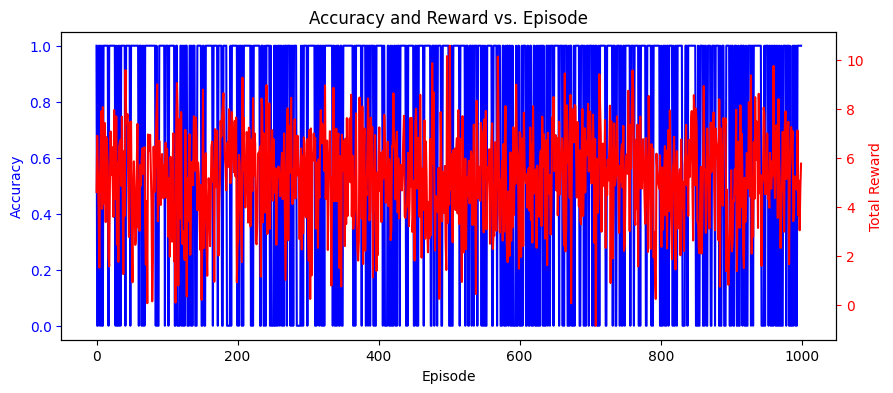

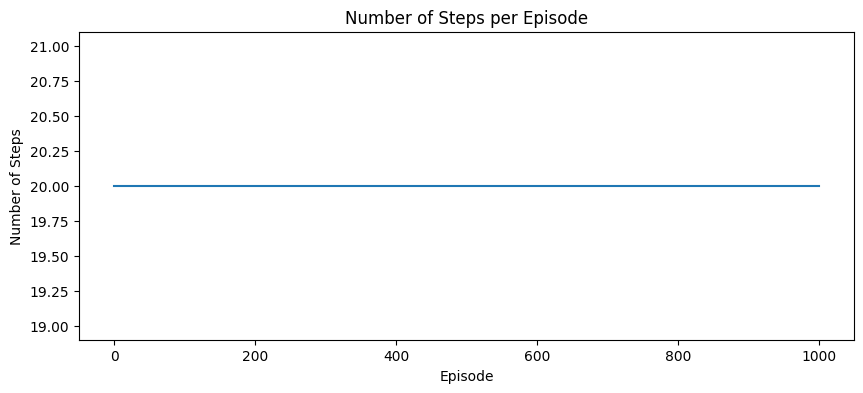

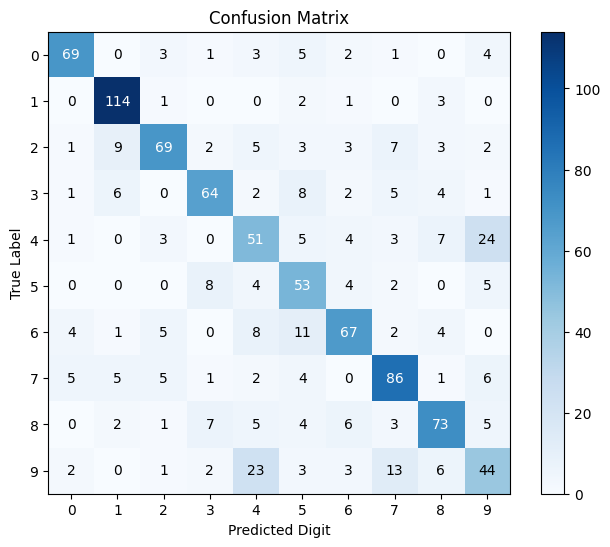

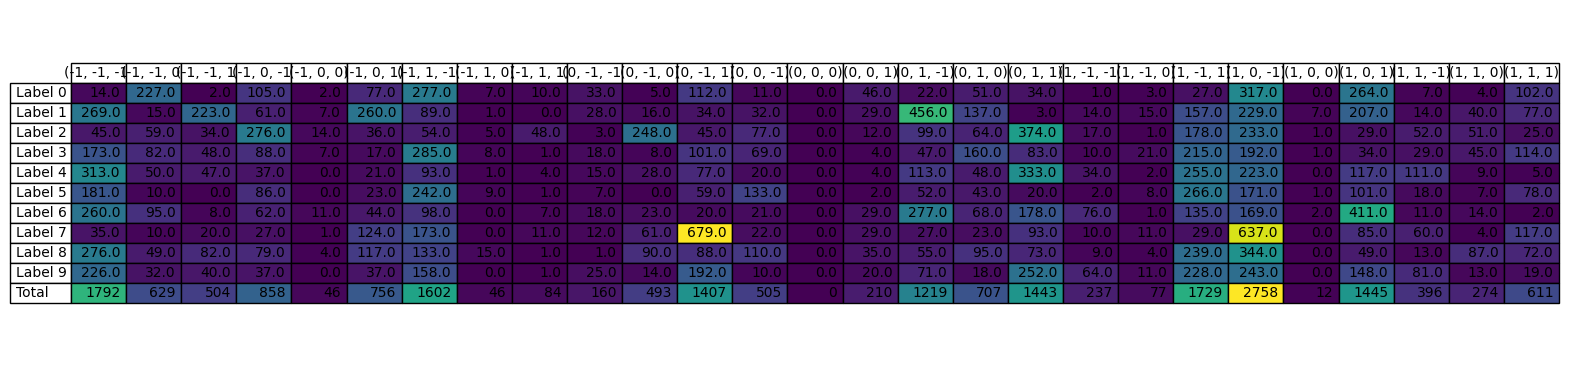

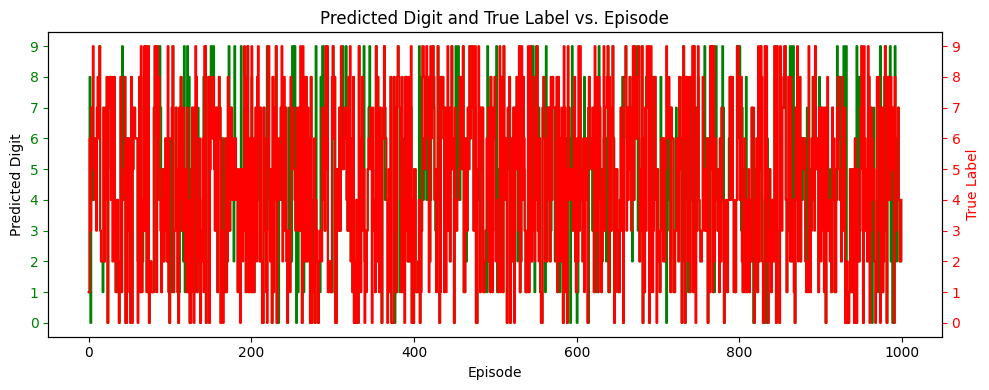

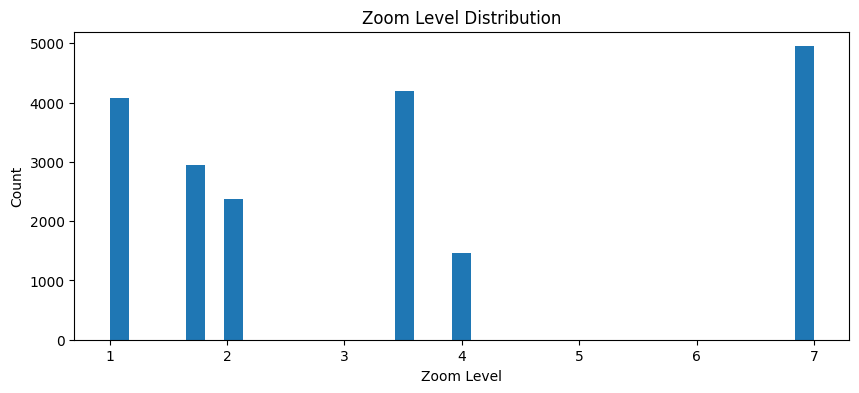

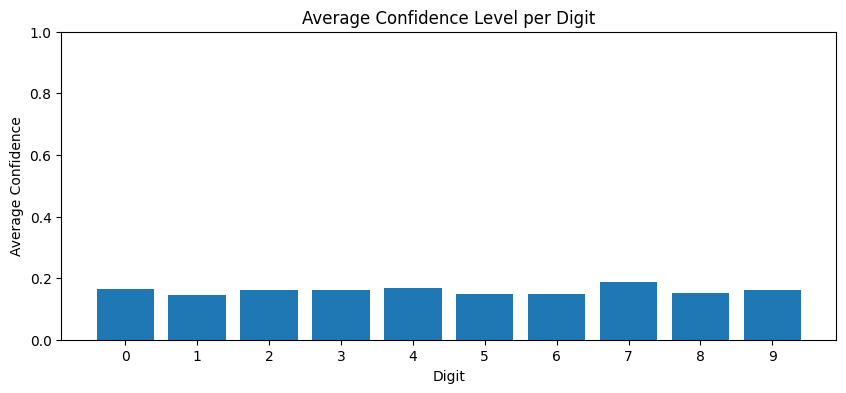

In [6]:
#@title Charts for testing
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import itertools

# --- Load the training data ---
with open('lstm_testing_data.json', 'r') as f:
    training_data = json.load(f)

# --- Extract data ---
episode_numbers = [data['episode'] for data in training_data]
accuracies = [data['accuracy'] for data in training_data]
rewards = [data['total_reward'] for data in training_data]
predicted_digits = [data['predicted_digit'] for data in training_data]
true_labels = [data['true_label'] for data in training_data]
steps_per_episode = [len(data['actions']) for data in training_data]
zoom_levels = [state[16] for data in training_data for state in data['states']] # Extract zoom levels

# --- Visualization 1: Accuracy and Reward vs. Episode ---
fig, ax1 = plt.subplots(figsize=(10, 4))
ax2 = ax1.twinx()

ax1.plot(episode_numbers, accuracies, 'b-', label='Accuracy')
ax2.plot(episode_numbers, rewards, 'r-', label='Reward')

ax1.set_xlabel('Episode')
ax1.set_ylabel('Accuracy', color='b')
ax2.set_ylabel('Total Reward', color='r')
ax1.tick_params('y', colors='b')
ax2.tick_params('y', colors='r')

plt.title('Accuracy and Reward vs. Episode')
plt.show()

# --- Visualization 4: Steps per Episode ---
plt.figure(figsize=(10, 4))
plt.plot(episode_numbers, steps_per_episode)
plt.xlabel('Episode')
plt.ylabel('Number of Steps')
plt.title('Number of Steps per Episode')
plt.show()

# --- Visualization 2: Confusion Matrix ---
confusion_matrix = np.zeros((10, 10), dtype=int)
for t, p in zip(true_labels, predicted_digits):
    confusion_matrix[t, p] += 1

plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.xlabel('Predicted Digit')
plt.ylabel('True Label')

for i in range(10):
    for j in range(10):
        plt.text(j, i, confusion_matrix[i, j],
                 ha='center', va='center',
                 color='w' if confusion_matrix[i, j] > 50 else 'black')
plt.show()

# --- Visualization 3: Action Combination Counts per True Label ---
all_possible_actions = list(itertools.product([-1, 0, 1], [-1, 0, 1], [-1, 0, 1]))
action_counts = {label: {tuple(action): 0 for action in all_possible_actions} for label in range(10)}

for data in training_data:
    true_label = data['true_label']
    for action in data['actions']:
        action_counts[true_label][tuple(action)] += 1

total_action_counts = np.zeros(len(all_possible_actions))
for label_counts in action_counts.values():
    for i, action in enumerate(all_possible_actions):
        total_action_counts[i] += label_counts[action]

table_data = np.array([[action_counts[label][a] for a in all_possible_actions] for label in range(10)])
table_data = np.vstack([table_data, np.zeros_like(total_action_counts)])

fig, ax = plt.subplots(figsize=(16, 4.5))
table = ax.table(cellText=table_data,
                  rowLabels=[f'Label {i}' for i in range(10)] + ['Total'],
                  colLabels=[str(a) for a in all_possible_actions],
                  loc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
ax.axis('off')

cell_colors = plt.cm.viridis(table_data[:-1] / table_data[:-1].max())
for i in range(table_data.shape[0] - 1):
    for j in range(table_data.shape[1]):
        table[i + 1, j].set_facecolor(cell_colors[i, j])

heatmap_data = np.array([total_action_counts])
heatmap_colors = plt.cm.viridis(heatmap_data / heatmap_data.max())

for j in range(table_data.shape[1]):
    table[table_data.shape[0], j].set_facecolor(heatmap_colors[0, j])
    table[table_data.shape[0], j].get_text().set_text(f'{int(total_action_counts[j])}')

plt.show()

# --- Visualization 5: Predicted Digit and True Label vs. Episode ---
fig, ax3 = plt.subplots(figsize=(10, 4))

# Plot predicted digit and true label on the bottom subplot
ax3.plot(episode_numbers, predicted_digits, 'g-', label='Predicted Digit', drawstyle='steps-post')
ax4 = ax3.twinx()
ax4.plot(episode_numbers, true_labels, 'r-', label='True Label', drawstyle='steps-post')
ax3.set_xlabel('Episode')
ax3.set_ylabel('Predicted Digit')
ax4.set_ylabel('True Label', color='r')
ax3.tick_params('y', colors='g')
ax4.tick_params('y', colors='r')
ax3.set_yticks(range(0, 10))
ax4.set_yticks(range(0, 10))
ax3.title.set_text('Predicted Digit and True Label vs. Episode')

plt.tight_layout()
plt.show()

# --- Visualization 6: Zoom Level Distribution ---
plt.figure(figsize=(10, 4))
plt.hist(zoom_levels, bins='auto')  # Let matplotlib automatically determine bins
plt.xlabel('Zoom Level')
plt.ylabel('Count')
plt.title('Zoom Level Distribution')
plt.show()

# --- Visualization 7: Average Confidence per Digit ---
confidence_per_digit = defaultdict(list)

for data in training_data:
    prediction_probs = np.array(data['prediction_probs'])
    final_confidence = np.max(prediction_probs[-1, :])
    true_label = data['true_label']
    confidence_per_digit[true_label].append(final_confidence)

avg_confidence = [np.mean(confidence_per_digit[digit]) for digit in range(10)]

plt.figure(figsize=(10, 4))
plt.bar(range(10), avg_confidence)
plt.xlabel('Digit')
plt.ylabel('Average Confidence')
plt.title('Average Confidence Level per Digit')
plt.xticks(range(10))
plt.ylim(0, 1)  # Confidence should be between 0 and 1
plt.show()

11490434/11490434 [==============================] - 0s 0us/step


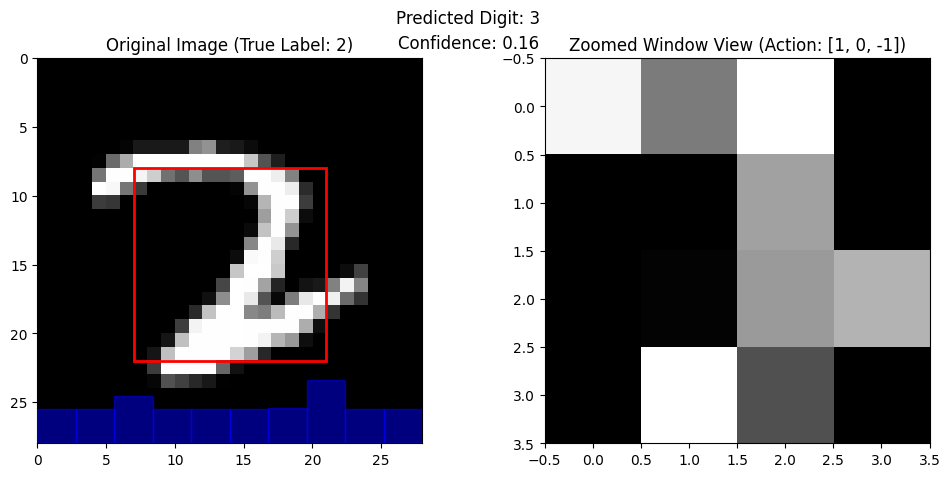

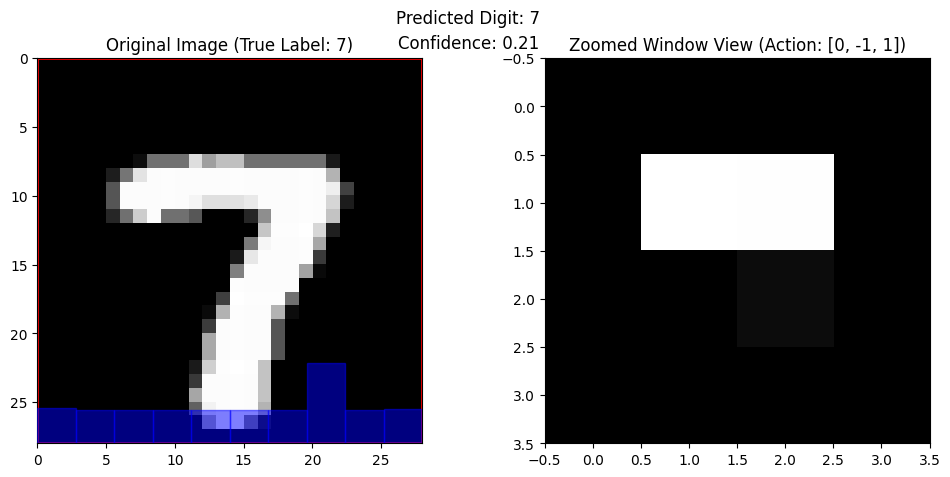

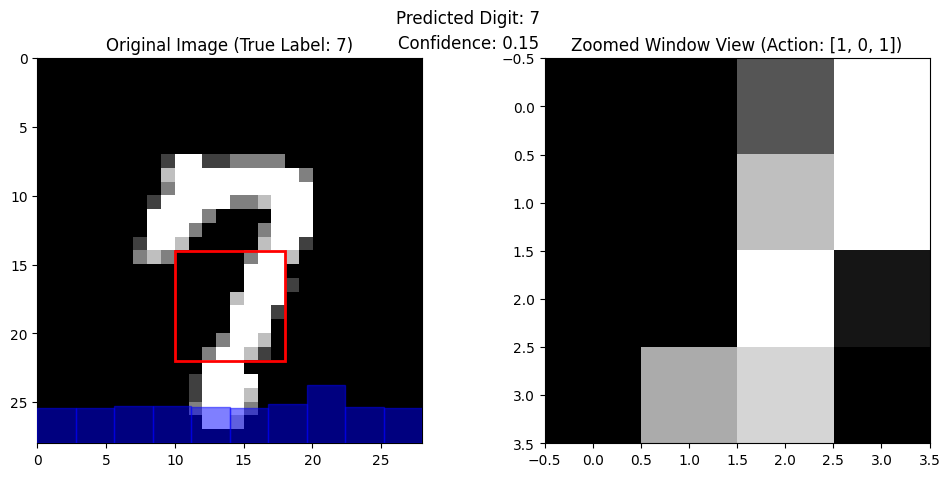

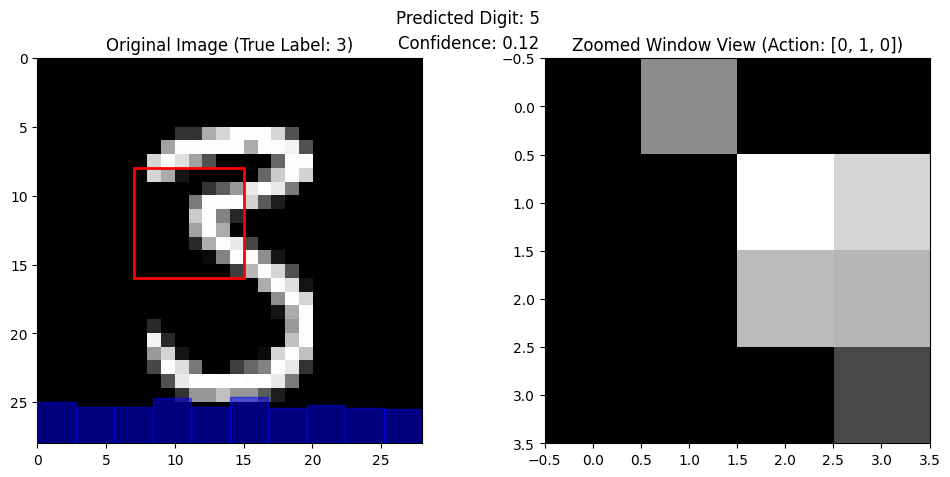

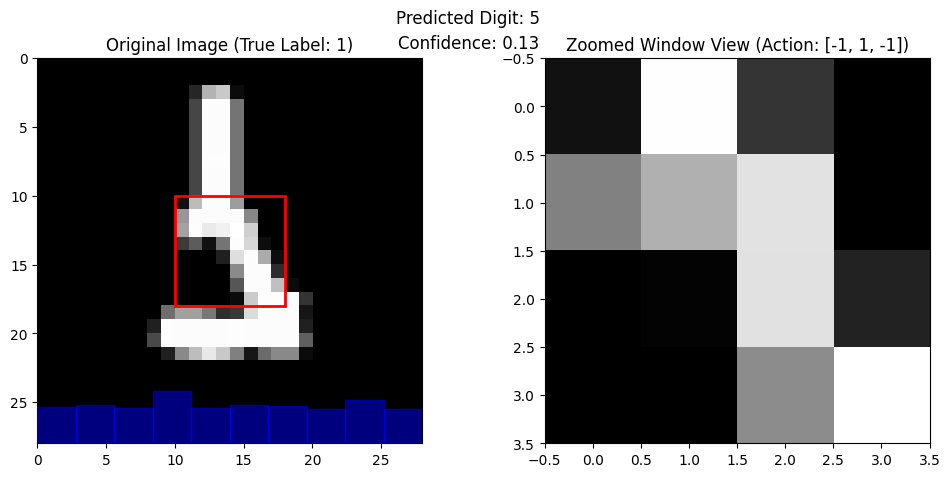

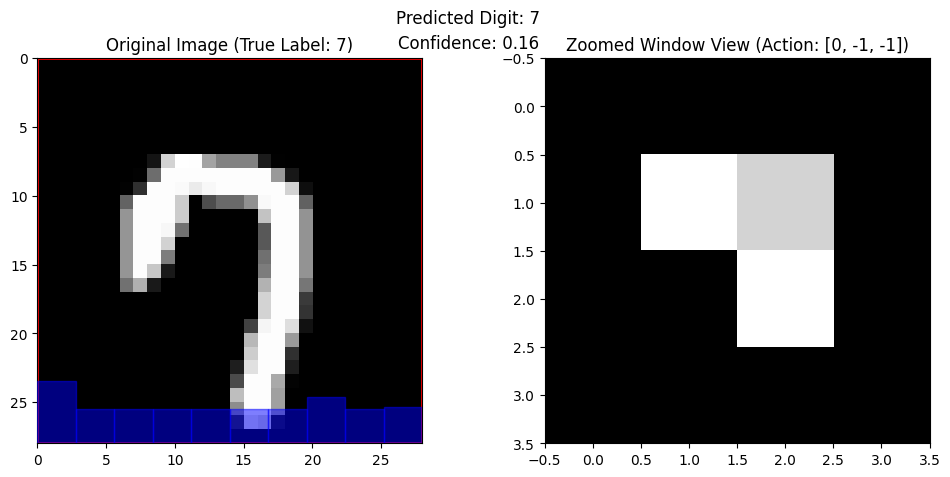

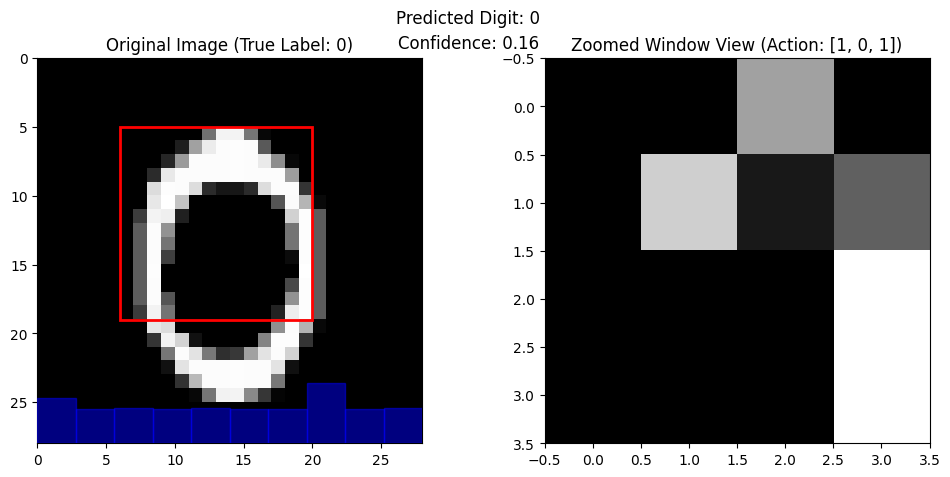

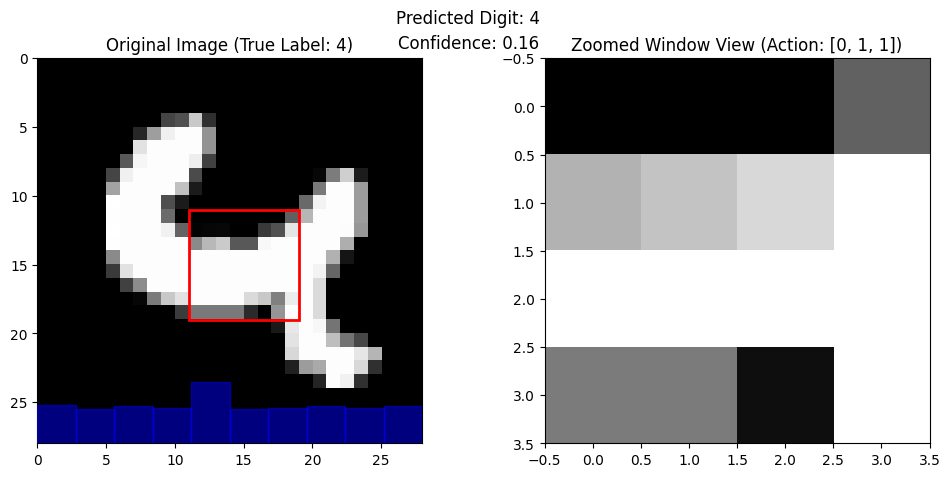

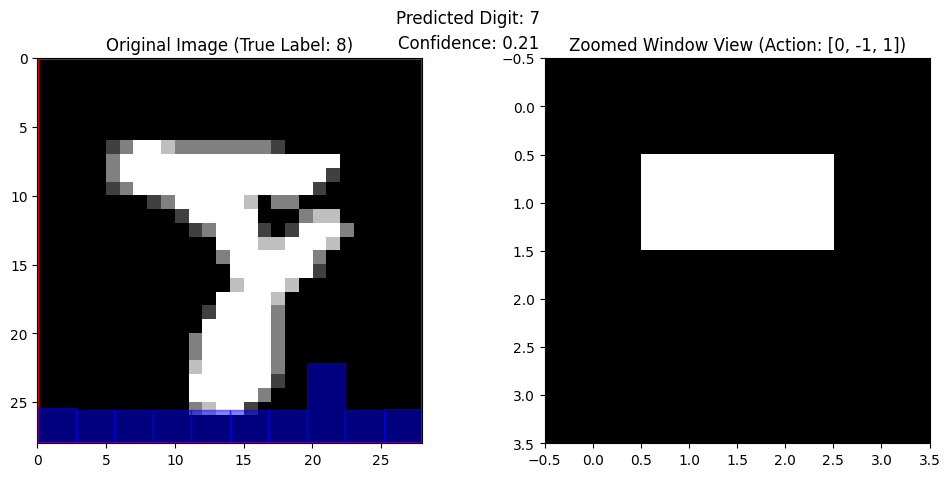

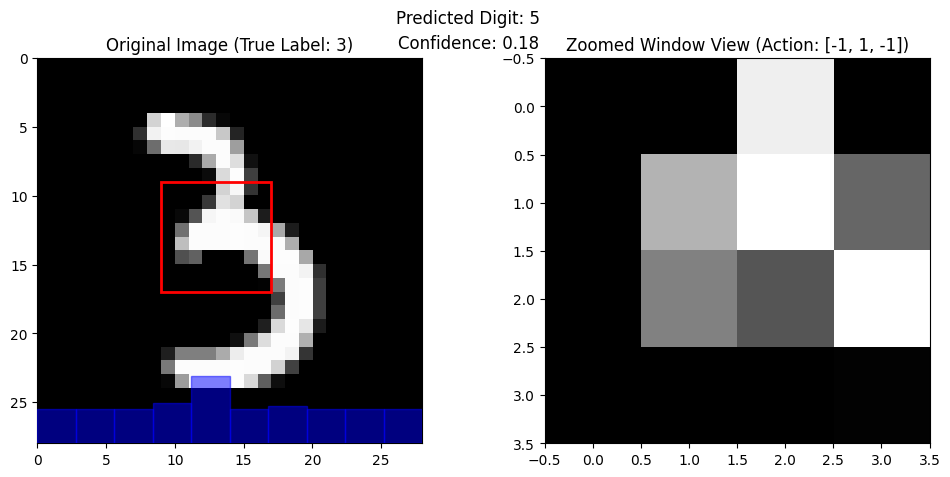

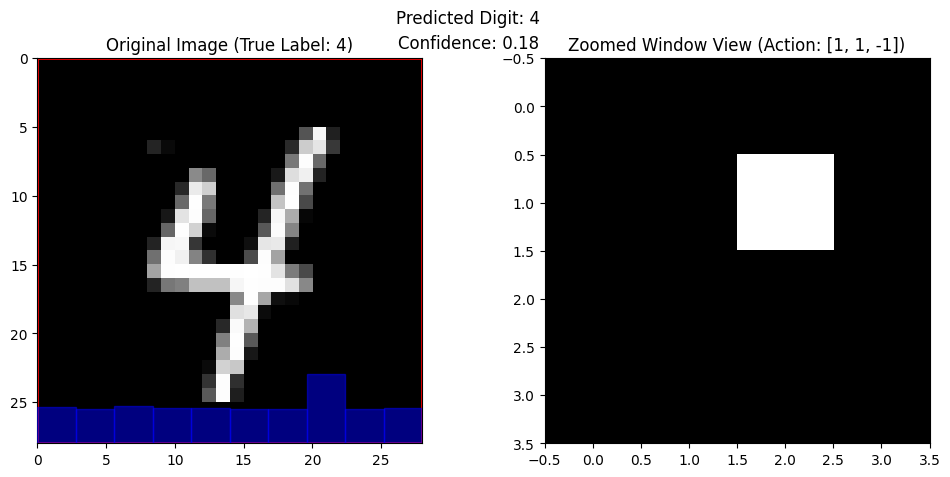

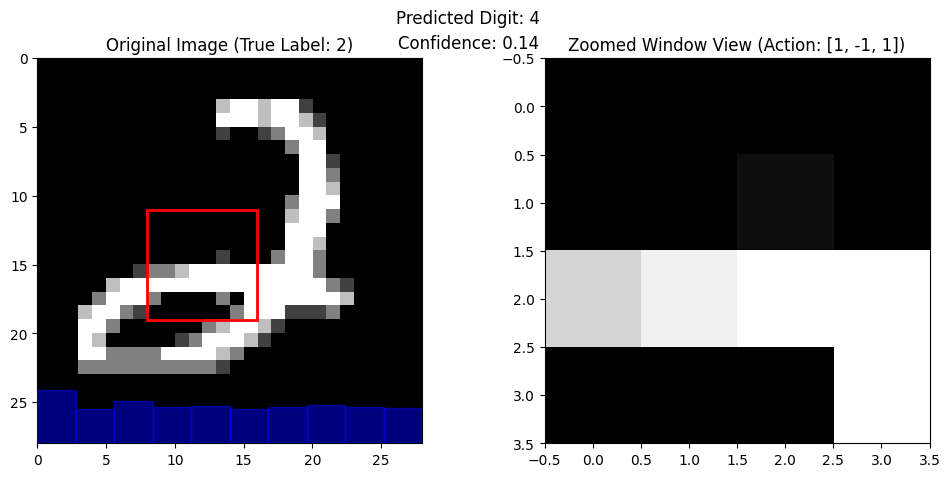

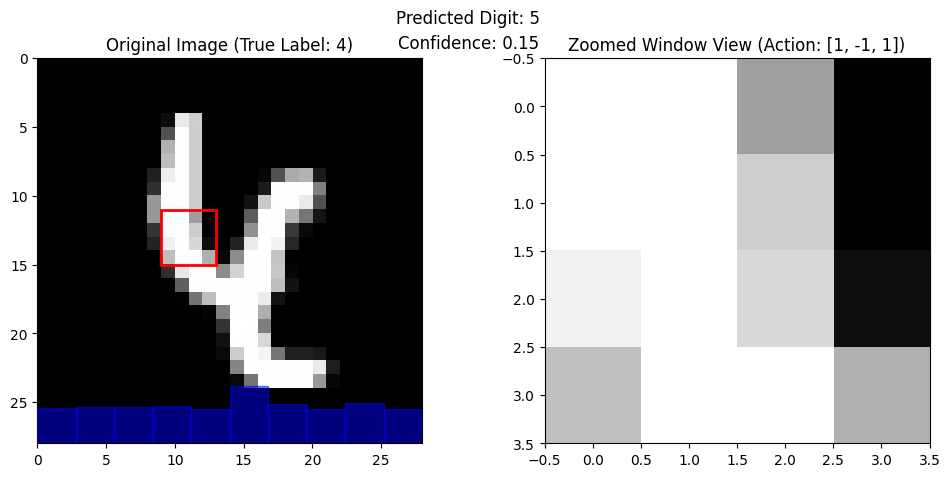

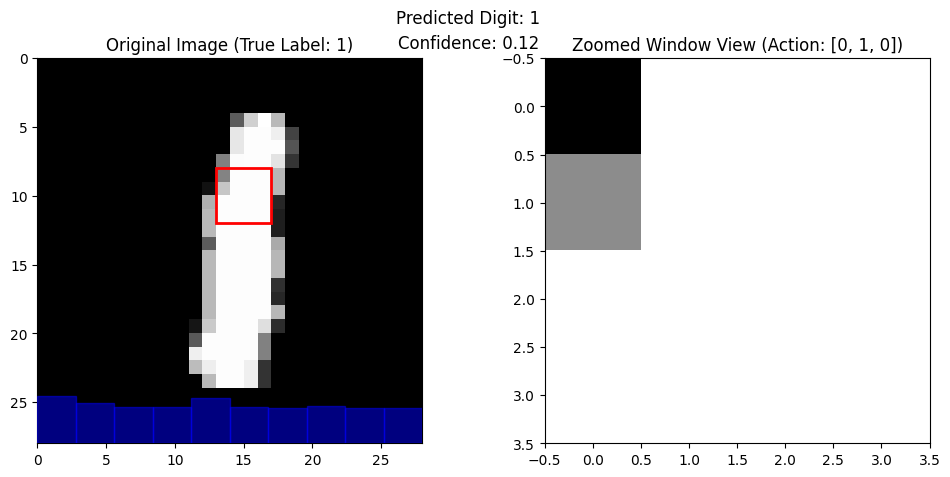

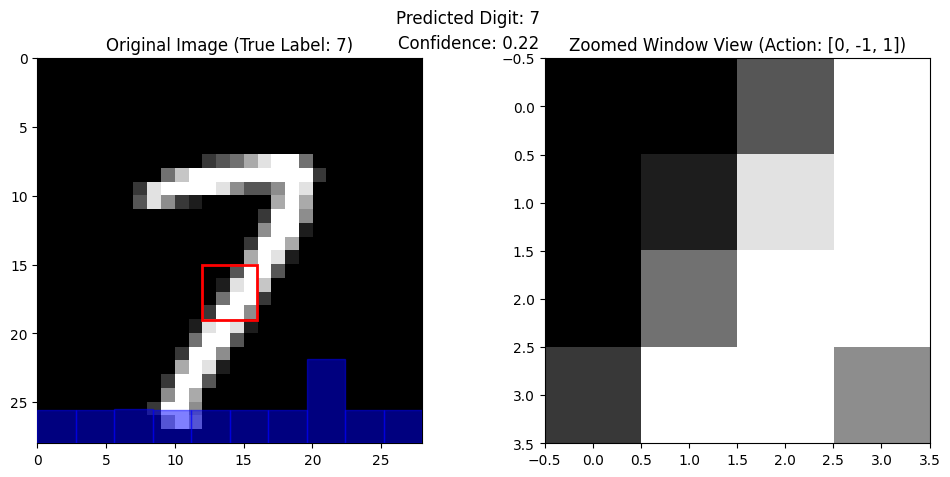

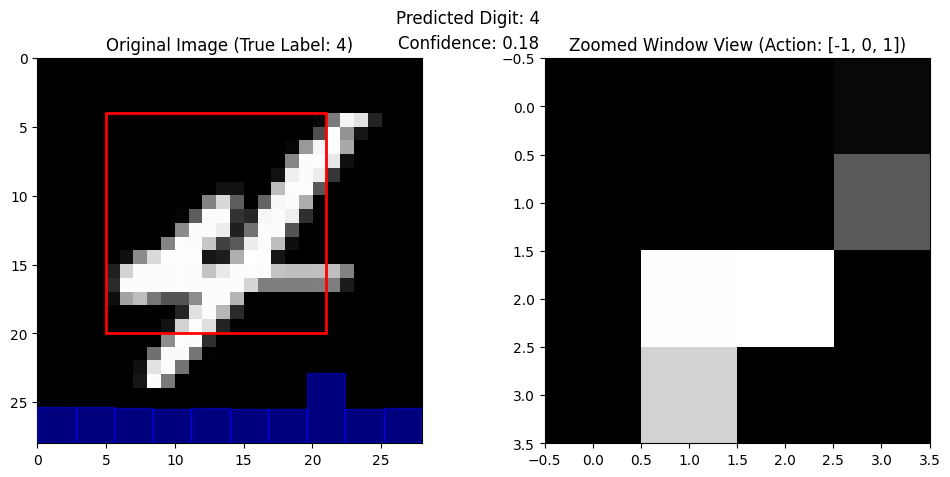

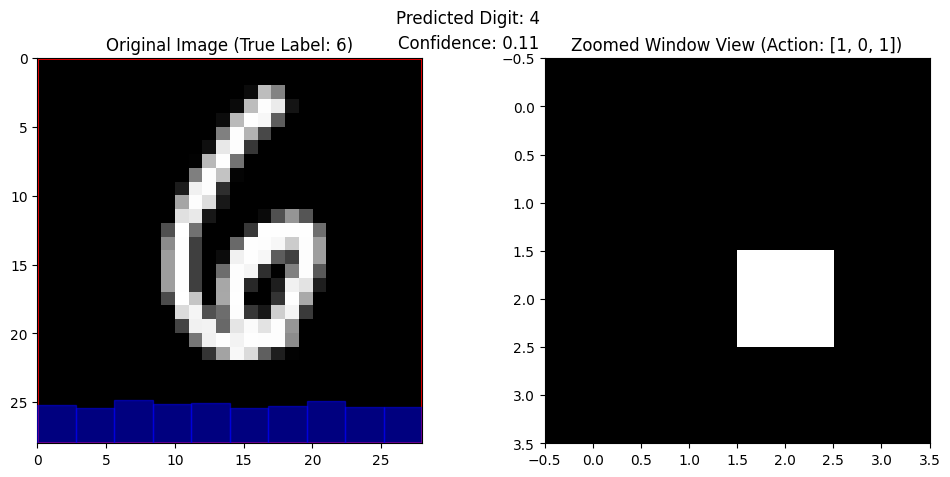

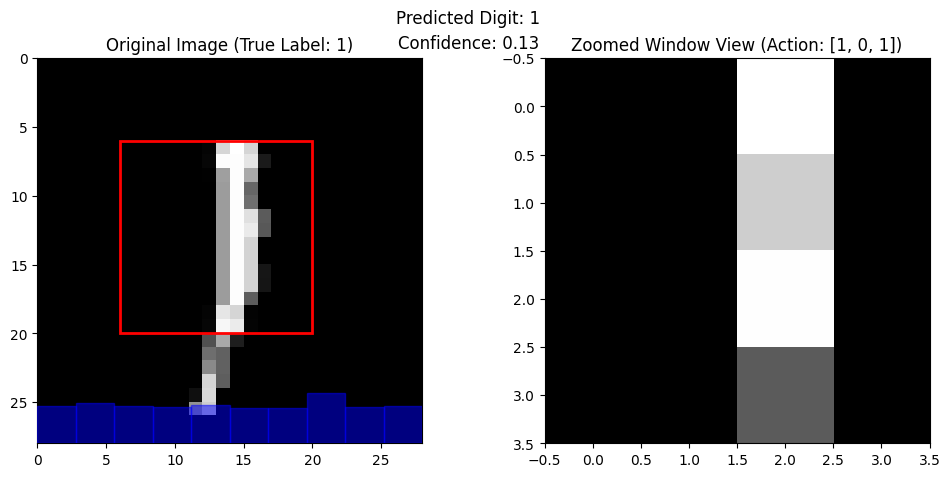

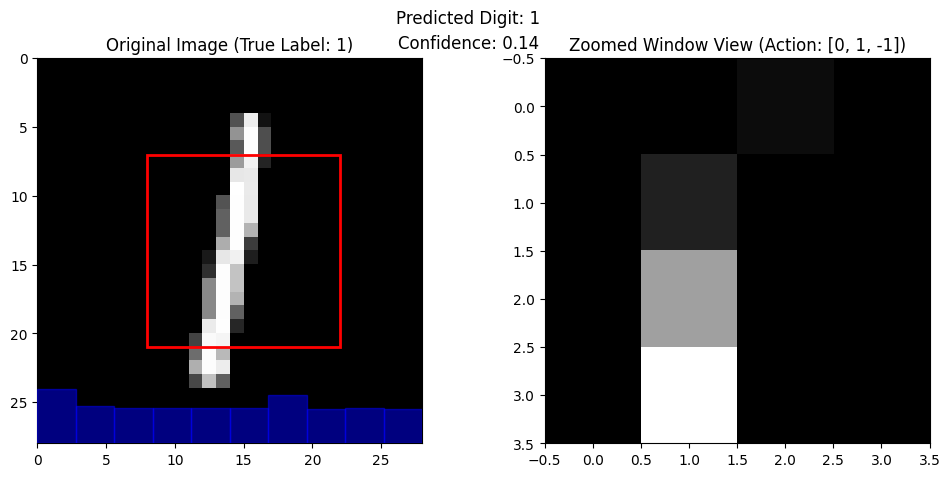

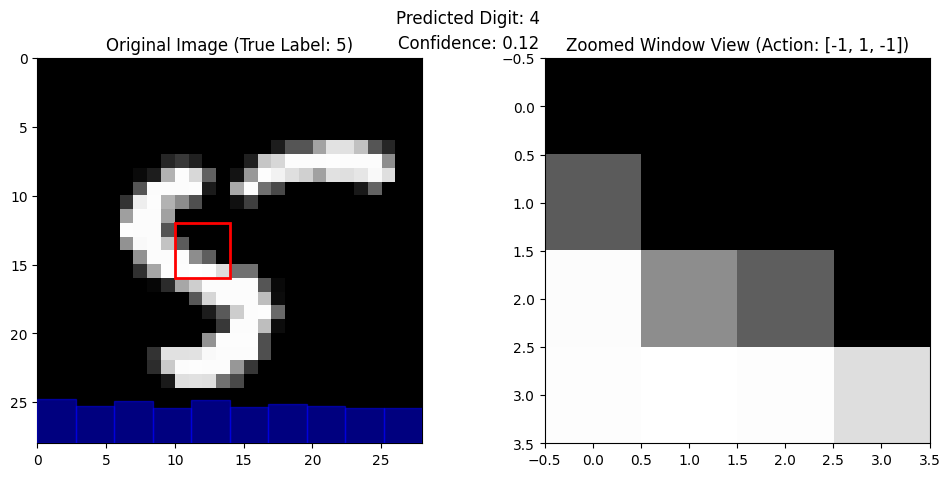

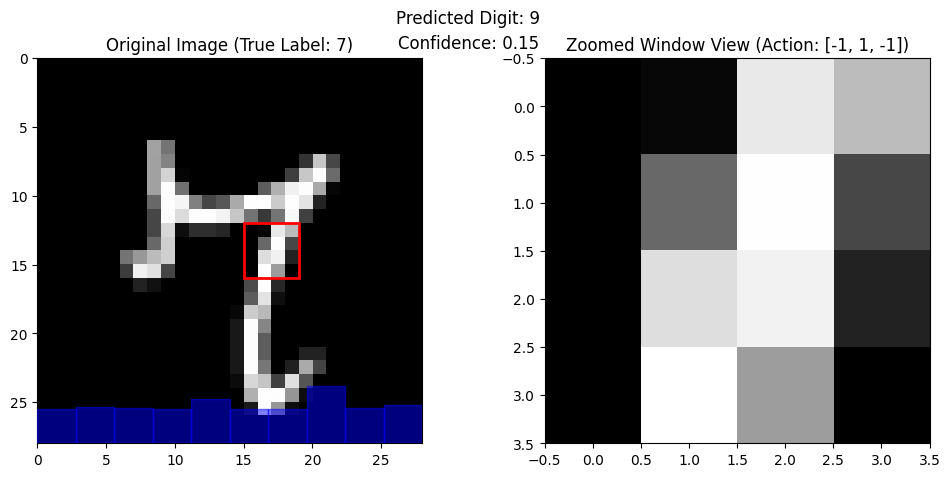

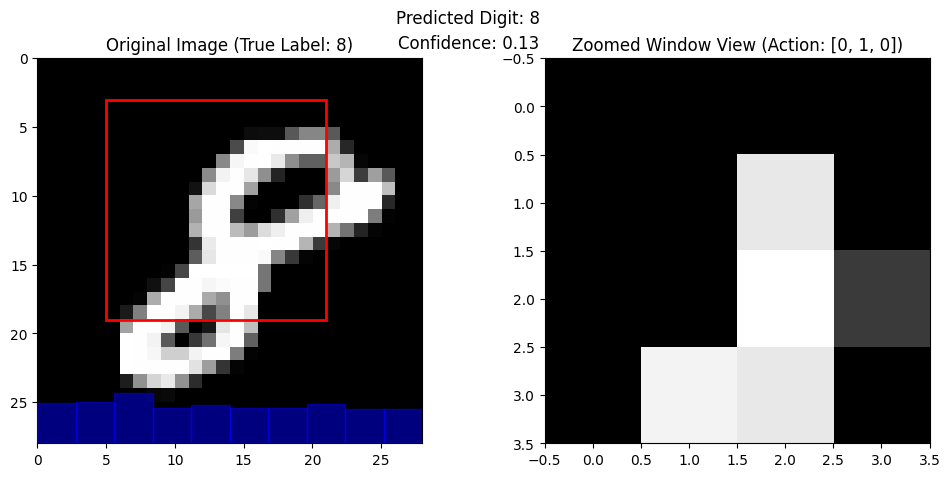

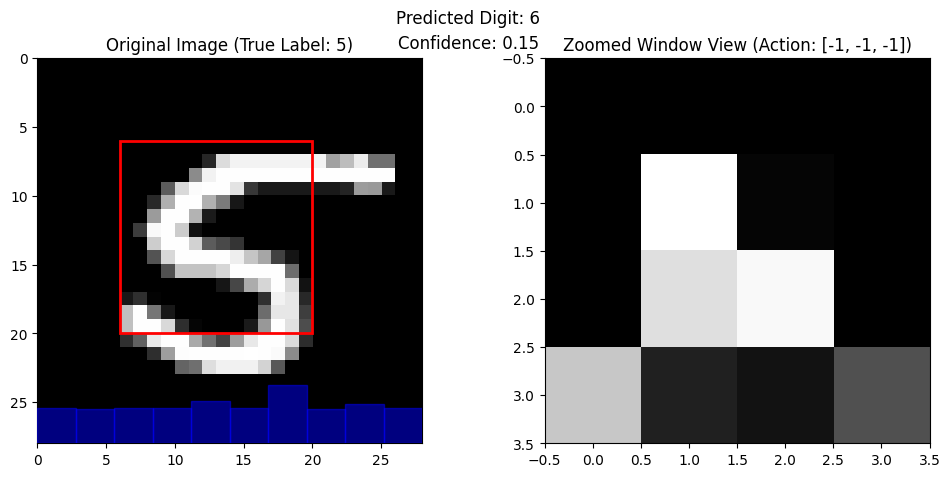

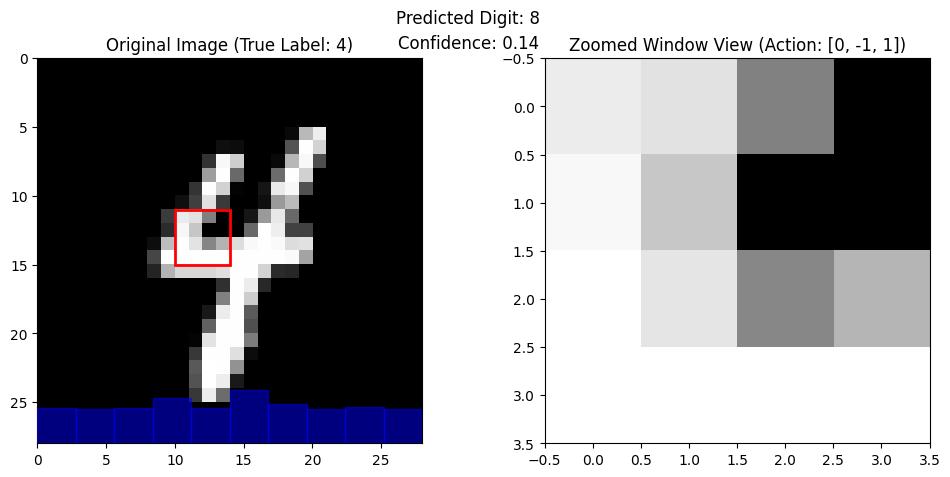

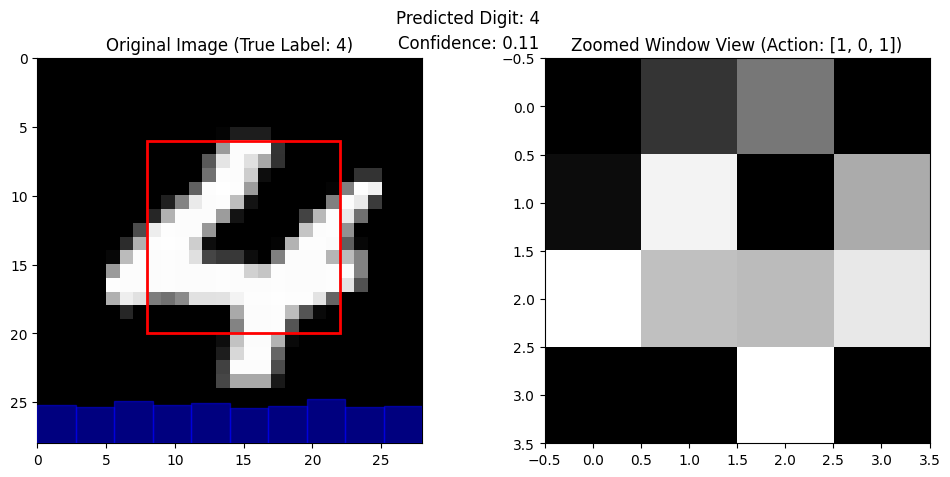

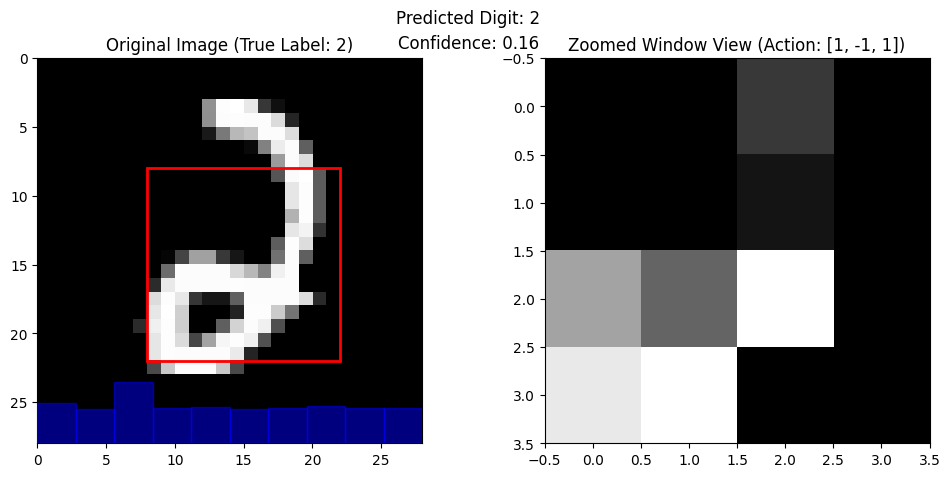

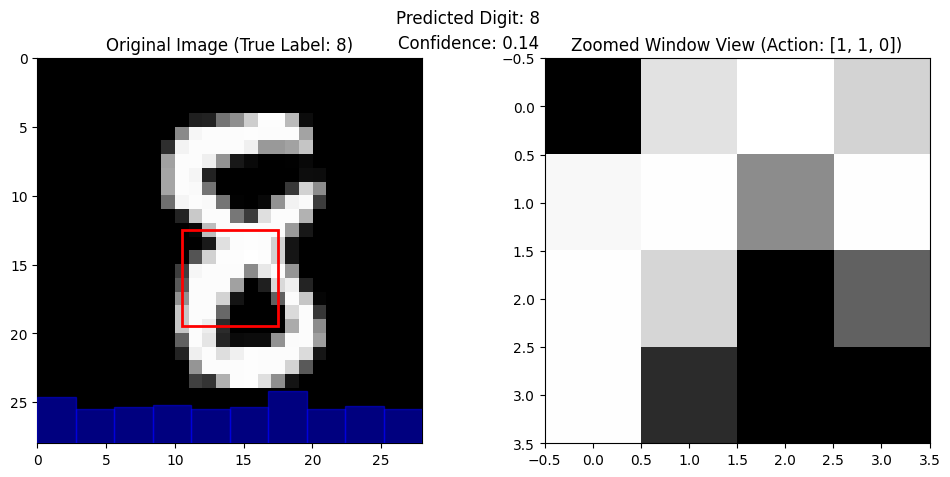

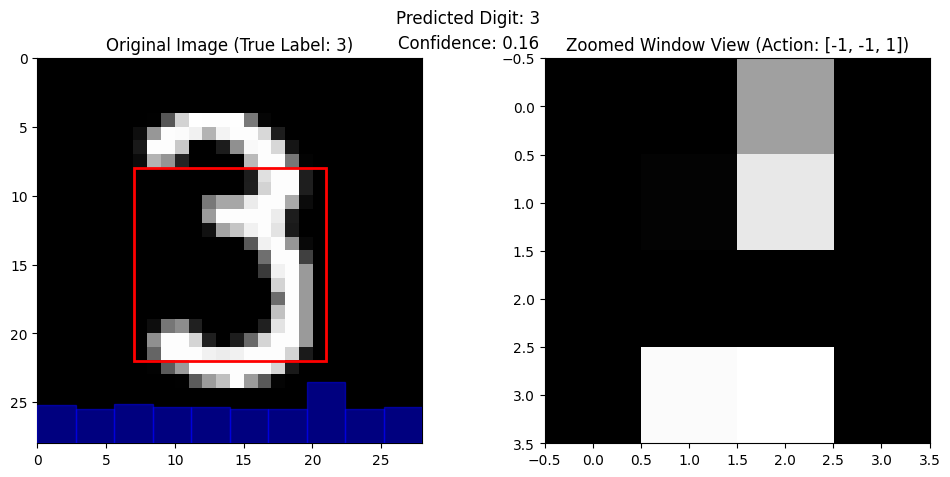

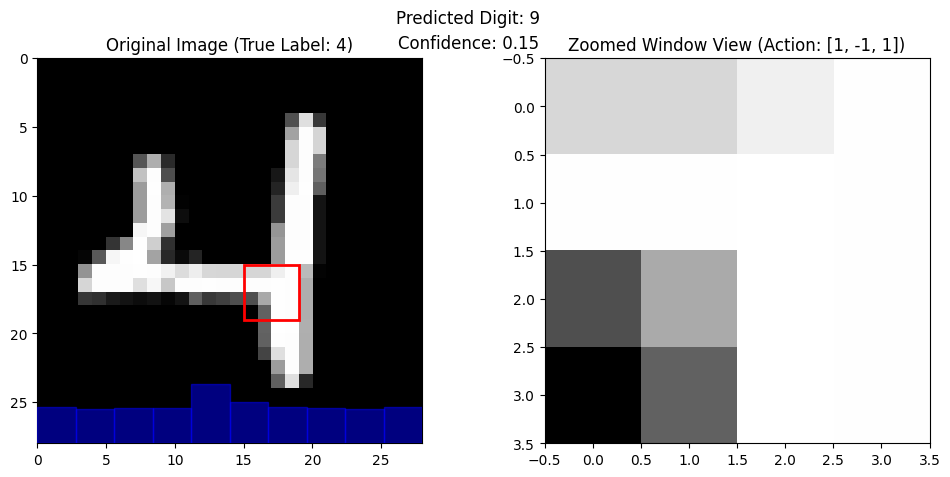

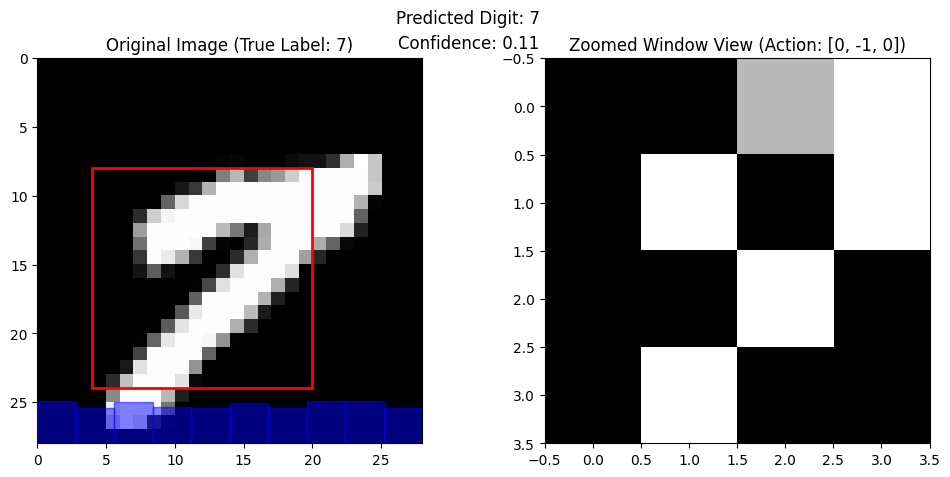

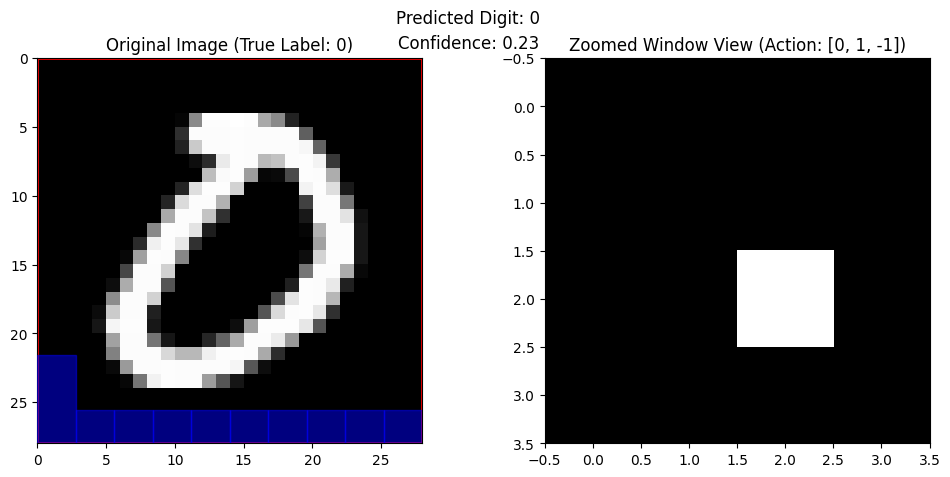

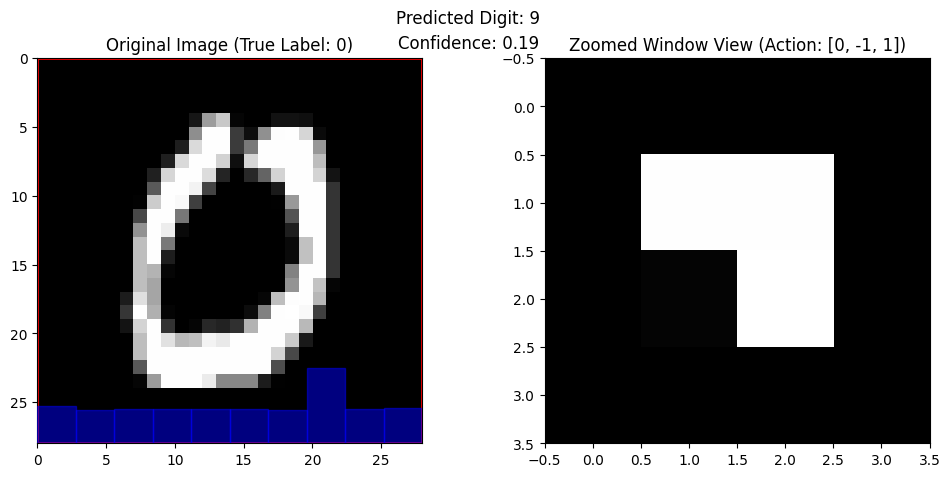

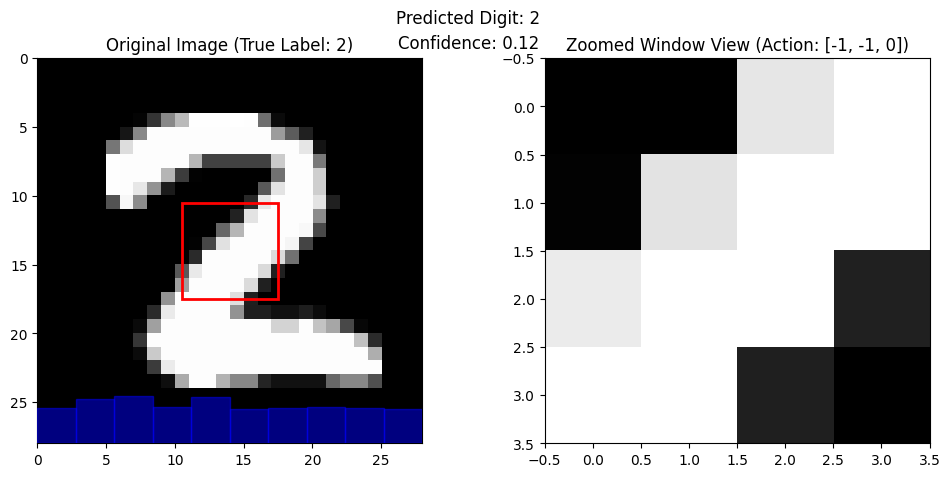

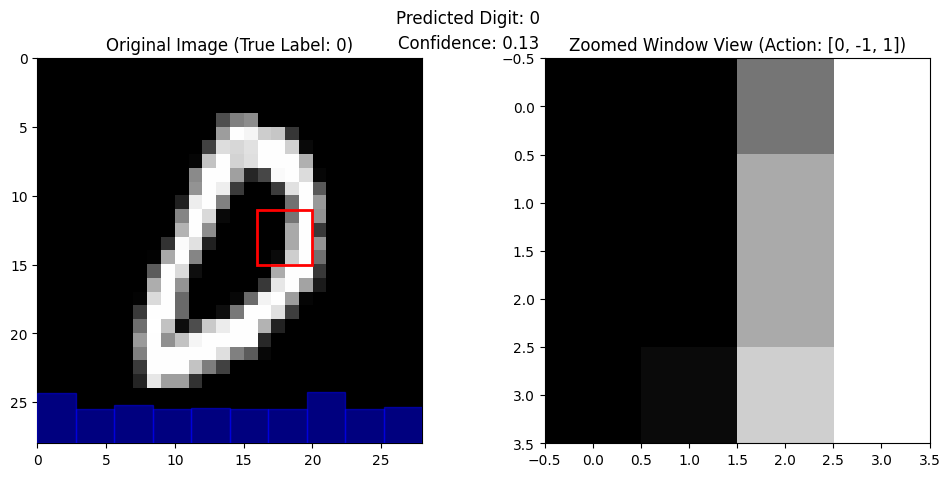

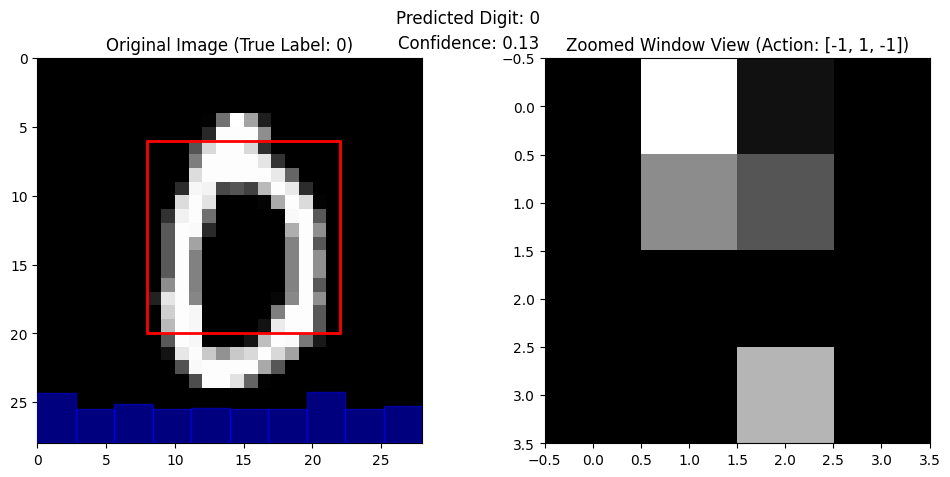

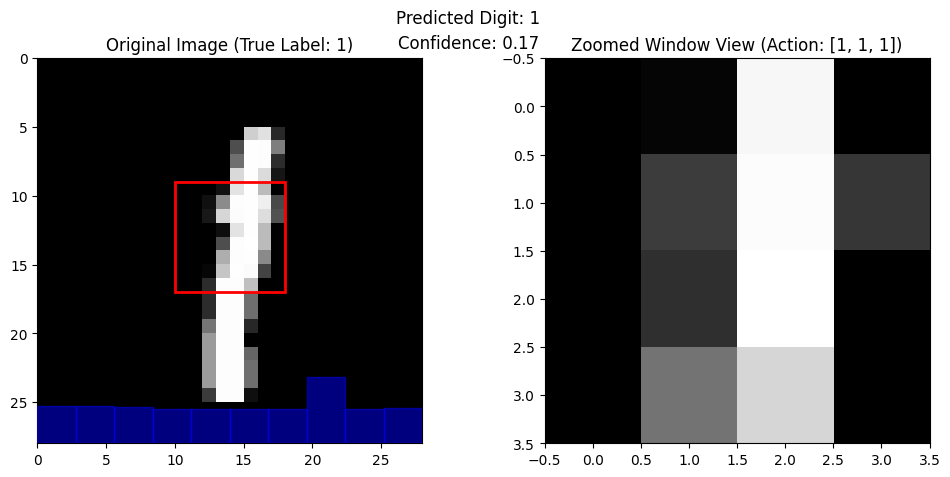

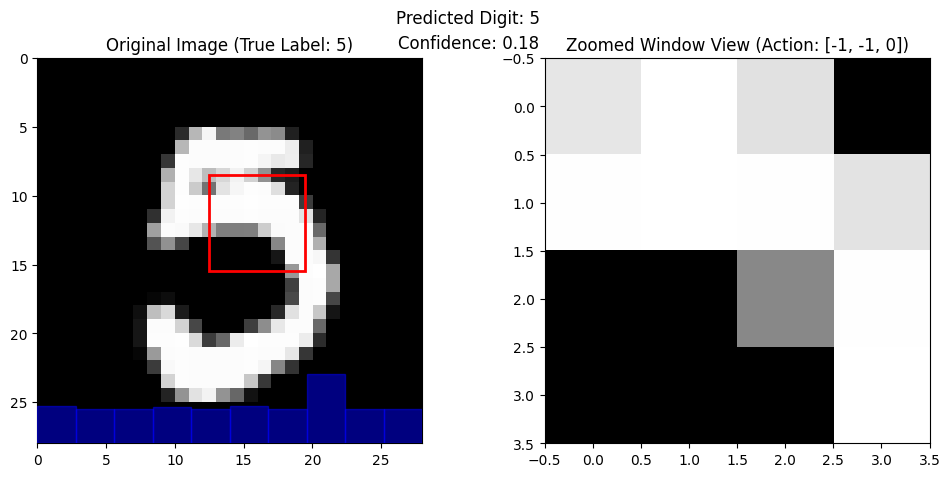

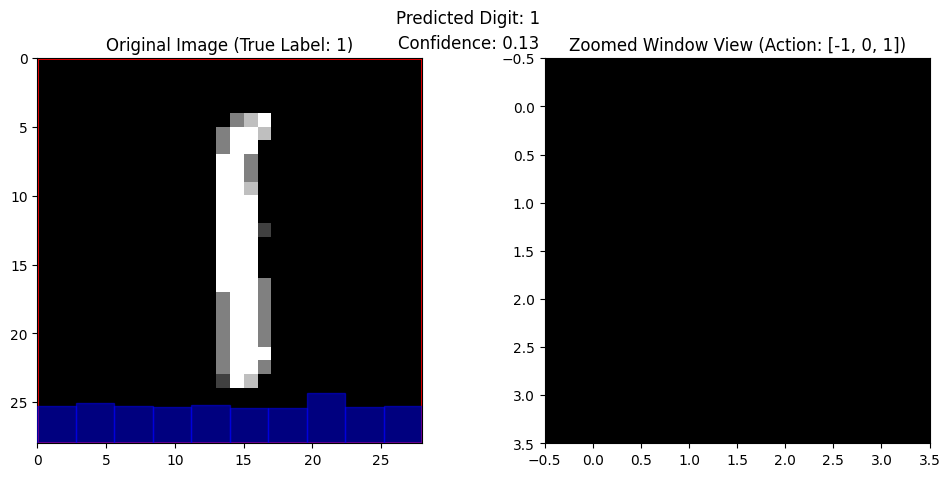

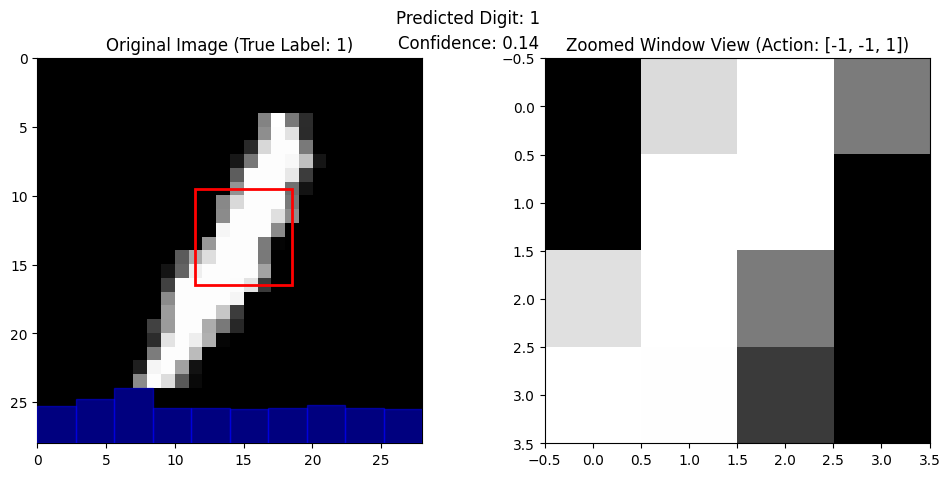

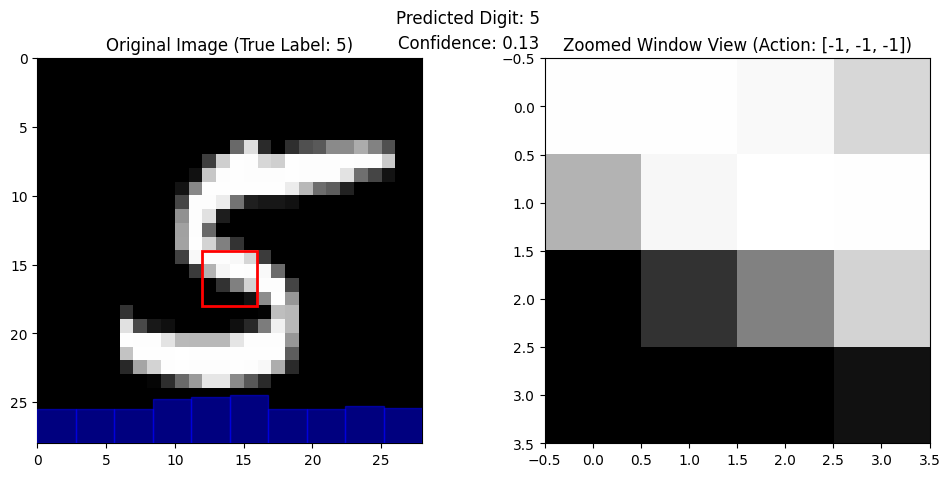

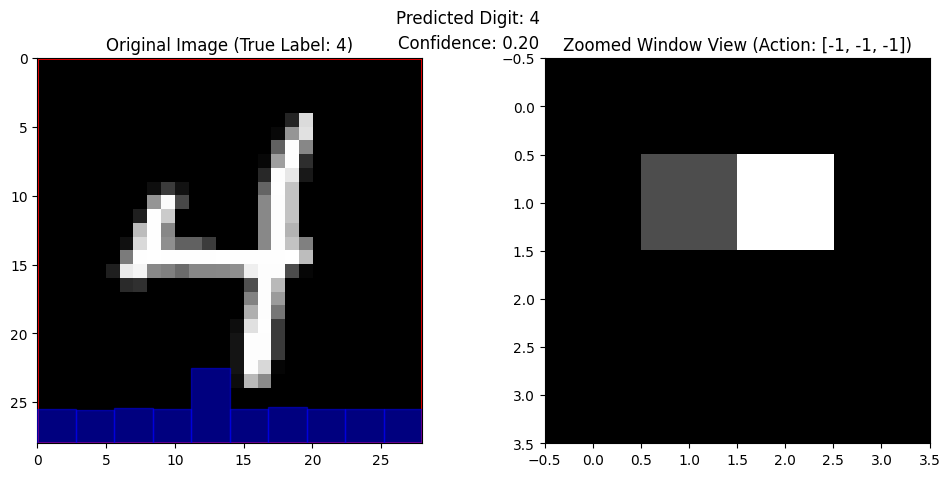

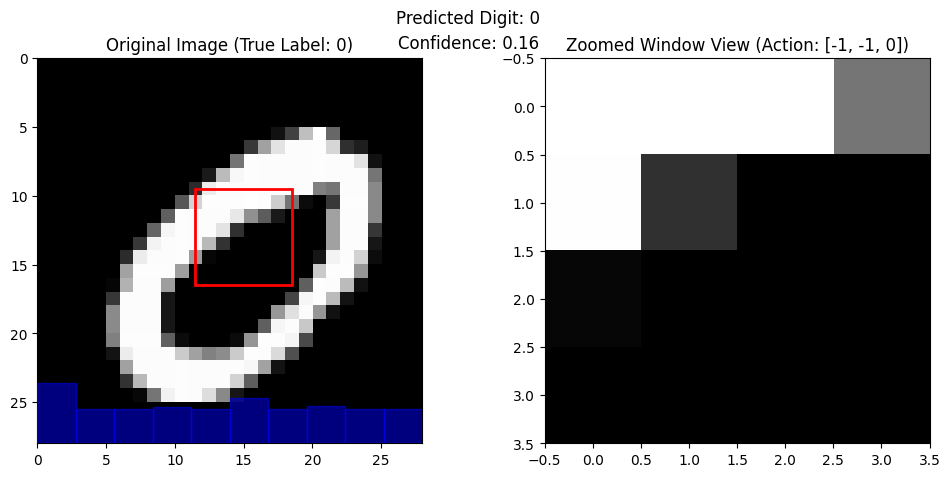

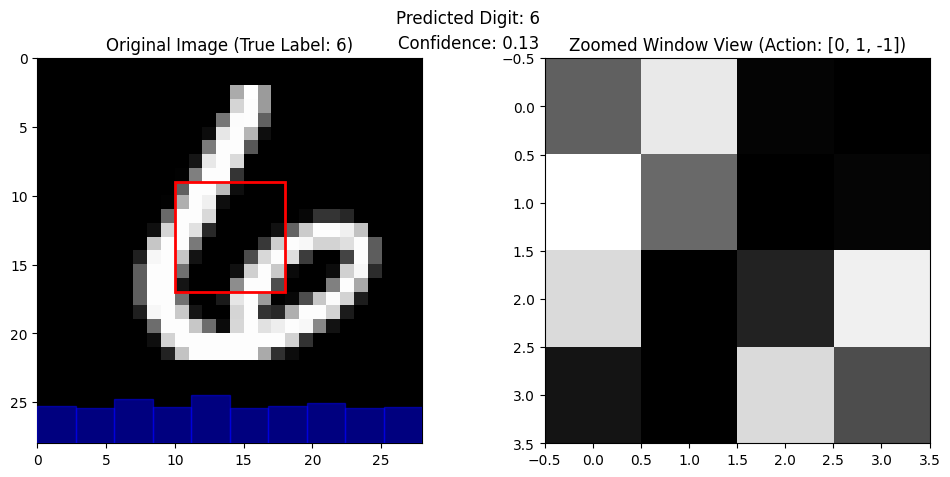

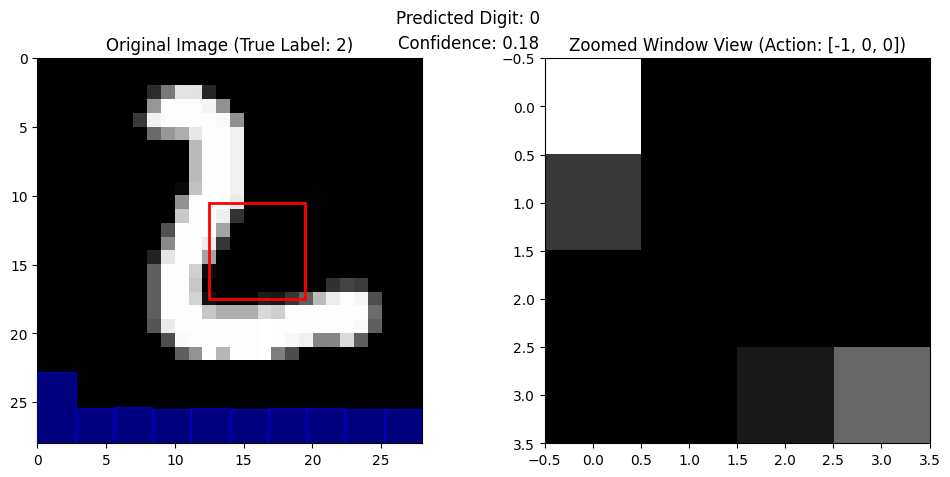

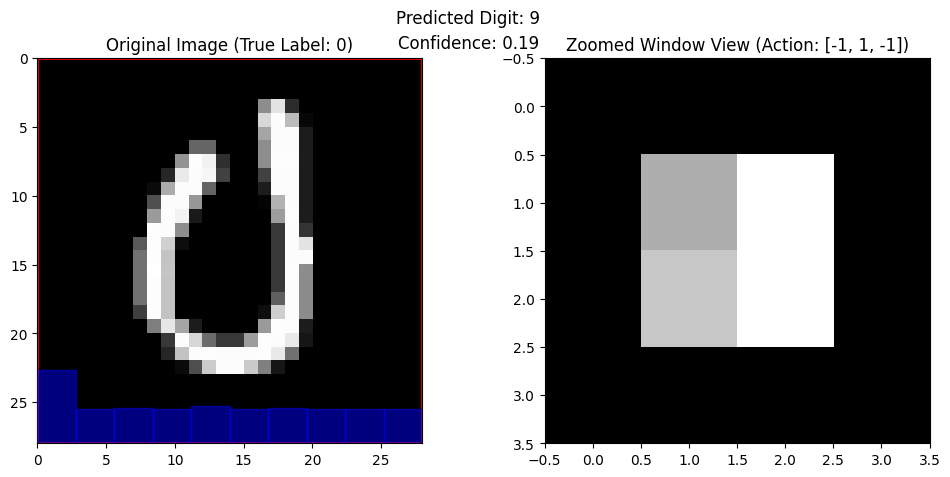

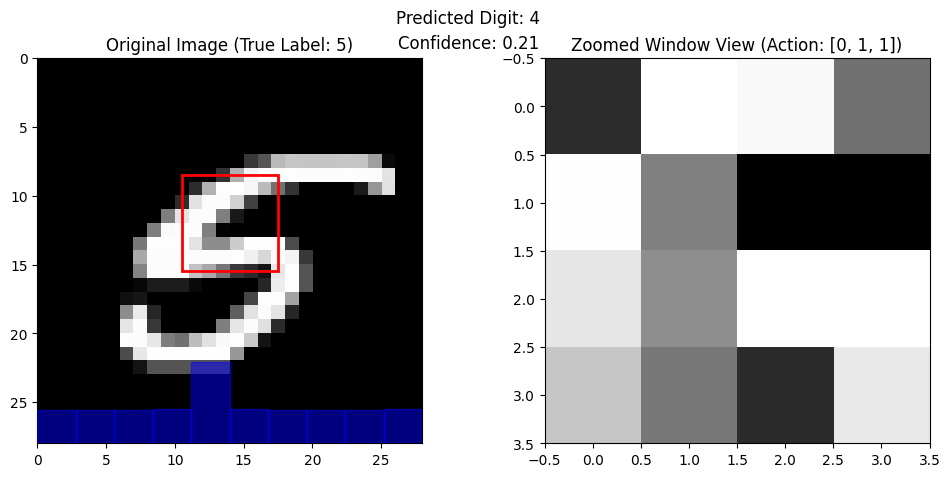

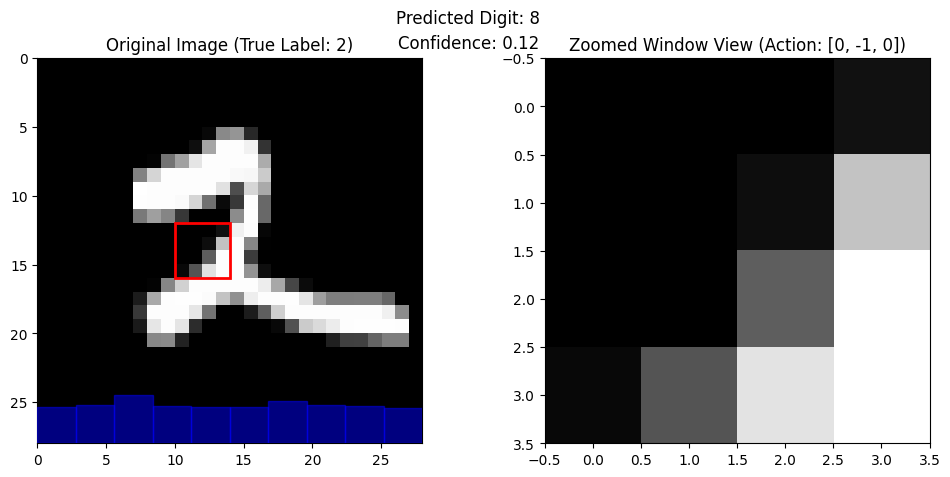

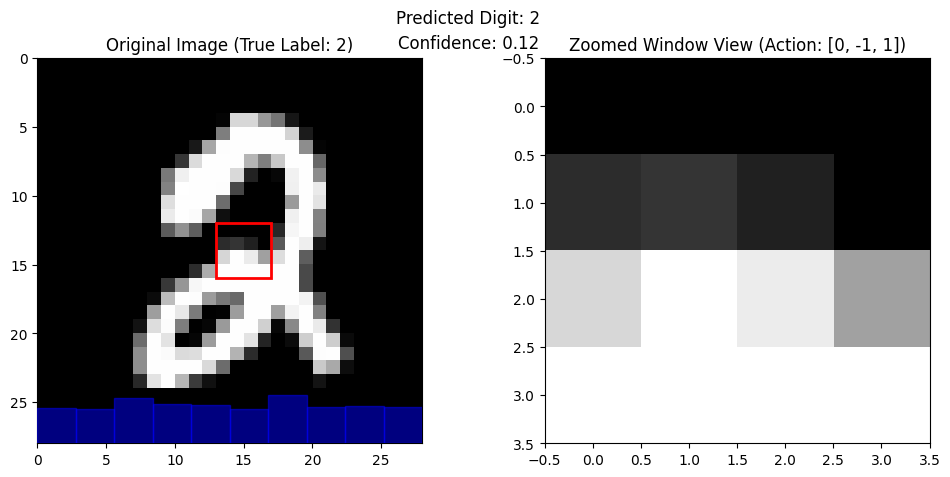

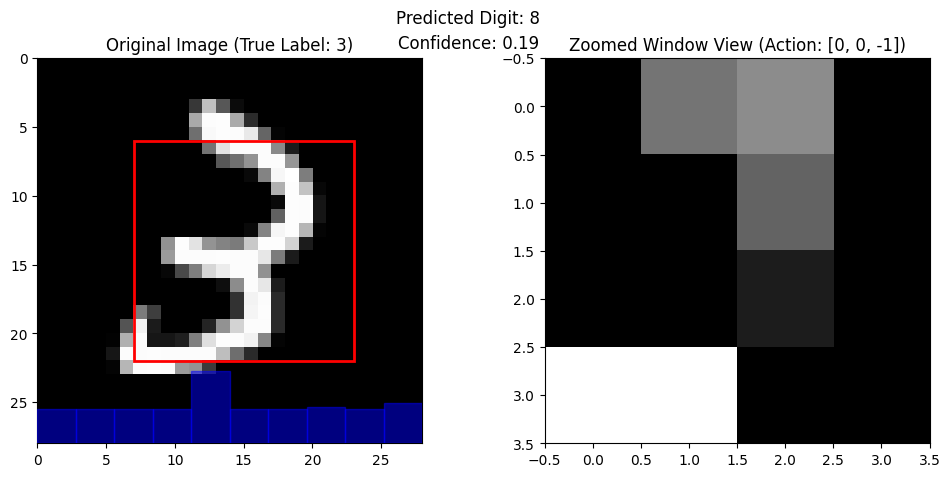

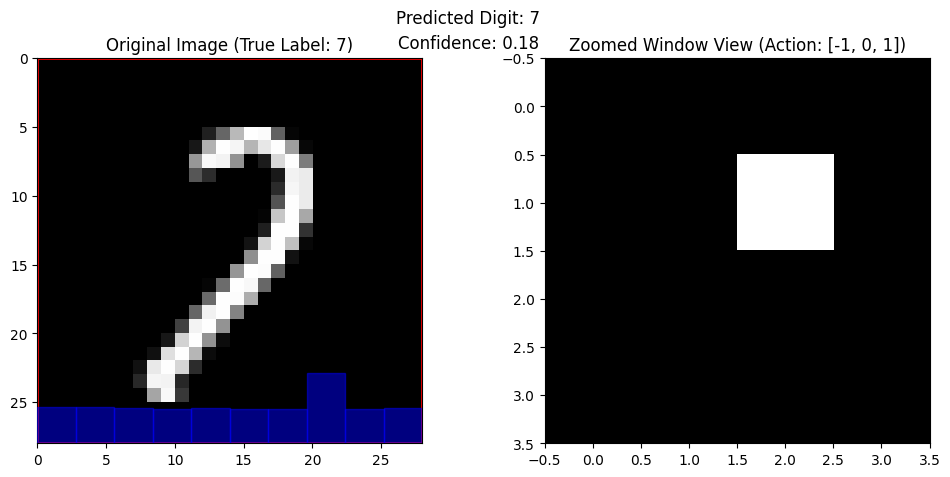

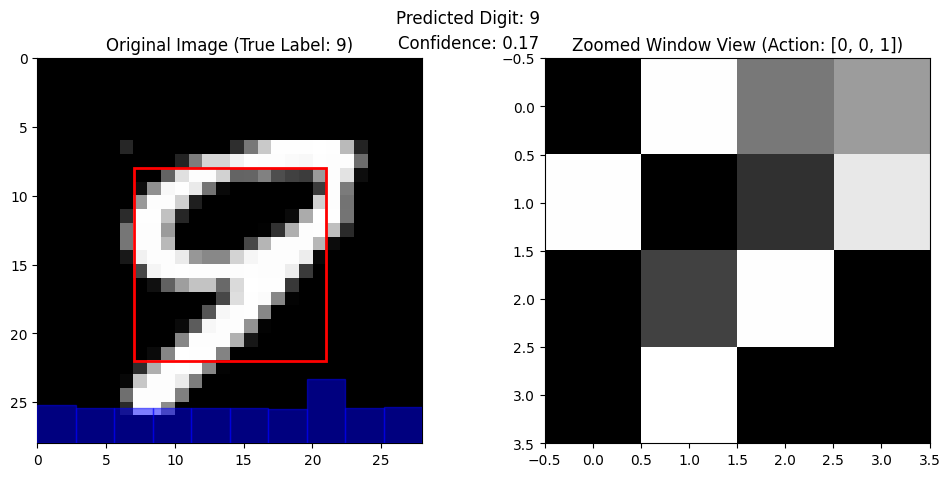

In [3]:
#@title Visualzier for testing
import json
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from tensorflow.keras.datasets import mnist
from matplotlib.animation import FFMpegWriter

def visualize_episode(episode_data, train_images):
    image_id = episode_data['image_id']
    states = episode_data['states']
    actions = episode_data['actions']
    true_label = episode_data['true_label']
    prediction_probs = episode_data['prediction_probs']
    predicted_digit = episode_data['predicted_digit']

    # Calculate final confidence
    final_confidence = max(prediction_probs[-1])

    image = train_images[image_id] / 255.0
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Set up the main image plot
    ax1.imshow(image, cmap='gray', extent=[0, 28, 28, 0])
    ax1.set_title(f"Original Image (True Label: {true_label})")

    # Set up the probability bar chart
    prob_ax = ax1.inset_axes([0, 0, 1, 1])
    prob_ax.set_xlim(0, 10)
    prob_ax.set_ylim(0, 1)
    prob_ax.axis('off')

    # Calculate bar width to fit 10 bars exactly in the 28-pixel width
    bar_width = 28 / 28

    # Create bars with calculated width and position
    bar_container = prob_ax.bar(
        np.arange(10) * bar_width + bar_width/2,
        np.zeros(10),
        width=bar_width,
        align='center',
        alpha=0.5
    )

    # Set up the zoomed window view
    ax2.set_title("Zoomed Window View")

    # Add text objects for static information
    fig.text(0.5, 0.95, f'Predicted Digit: {predicted_digit}', ha='center', fontsize=12)
    fig.text(0.5, 0.9, f'Confidence: {final_confidence:.2f}', ha='center', fontsize=12)

    def animate(i):
        state = states[i]
        window_view = np.array(state[:16]).reshape((4, 4))
        action = actions[i]
        zoom_level = state[16]
        probs = prediction_probs[i]

        ax2.cla()
        ax2.imshow(window_view, cmap='gray', interpolation='nearest')
        ax2.set_title(f"Zoomed Window View (Action: {action})")

        # Clear previous rectangles
        for patch in reversed(ax1.patches):
            patch.remove()

        # Draw new rectangle
        rect_width = rect_height = 4 * zoom_level
        x_pos = (state[-2])+14 - rect_width / 2
        y_pos = (state[-1])+14 - rect_height / 2
        rect = plt.Rectangle((x_pos, y_pos), rect_width, rect_height, linewidth=2, edgecolor='r', facecolor='none')
        ax1.add_patch(rect)

        # Update probability bars
        for bar, height in zip(bar_container, probs):
            bar.set_height(height)
            bar.set_color('blue')  # Set color explicitly

        return []

    ani = animation.FuncAnimation(fig, animate, frames=len(states), interval=50, blit=False, repeat=False)
    writer = FFMpegWriter(fps=10, metadata=dict(artist='Me'), bitrate=1800)
    ani.save(f"episode_{episode_data['episode']}_visualization.mp4", writer=writer)
    plt.show()

def main():
    (_, _), (test_images, test_labels) = mnist.load_data()
    with open('lstm_testing_data.json', 'r') as jsonfile:
        training_data = json.load(jsonfile)

    start_episode = int(input("Enter the starting episode number: "))
    end_episode = int(input("Enter the ending episode number: "))

    if start_episode < 0 or end_episode >= len(training_data) or start_episode > end_episode:
        print(f"Invalid episode range. Please choose a valid range between 0 and {len(training_data)-1}.")
    else:
        for episode_to_visualize in range(start_episode, end_episode + 1):
            visualize_episode(training_data[episode_to_visualize], test_images)

if __name__ == "__main__":
    main()


In [5]:
#@title download videos
import os
import zipfile
import ipywidgets as widgets
from IPython.display import display
from google.colab import files

def zip_and_download_videos():
    # Get all MP4 files in the current directory
    video_files = [f for f in os.listdir('.') if f.endswith('_visualization.mp4')]

    if not video_files:
        print("No video files found.")
        return

    print(f"Found {len(video_files)} video files.")

    # Create a progress bar
    progress = widgets.FloatProgress(value=0, min=0, max=len(video_files) + 1, description='Progress:')
    display(progress)

    # Create a zip file
    zip_filename = 'visualization_videos.zip'
    with zipfile.ZipFile(zip_filename, 'w') as zipf:
        for i, file in enumerate(video_files):
            zipf.write(file)
            progress.value = i + 1

    print("All videos zipped.")
    progress.value += 1

    # Download the zip file
    files.download(zip_filename)

    print("\nZip file downloaded!")

# Run the function
zip_and_download_videos()

Found 51 video files.


FloatProgress(value=0.0, description='Progress:', max=52.0)

All videos zipped.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Zip file downloaded!


In [2]:
#@title Accuracy Test
import json

def calculate_accuracy_from_json(file_path):
    with open(file_path, 'r') as f:
        test_data = json.load(f)

    total_episodes = len(test_data)
    correct_predictions = sum(episode['accuracy'] for episode in test_data)

    accuracy = correct_predictions / total_episodes

    print(f"Total episodes: {total_episodes}")
    print(f"Correct predictions: {correct_predictions}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Accuracy percentage: {accuracy * 100:.2f}%")

    return accuracy

# Usage
file_path = 'lstm_testing_data.json'
accuracy = calculate_accuracy_from_json(file_path)

Total episodes: 1000
Correct predictions: 690
Accuracy: 0.6900
Accuracy percentage: 69.00%


In [8]:
#@title Average episodes
import json
from typing import List, Dict, Any
from collections import defaultdict

def average_data(data: List[Dict[str, Any]]) -> Dict[int, Dict[str, List[Any]]]:
    grouped_data = defaultdict(lambda: {
        'states': [],
        'actions': [],
        'prediction_probs': [],
        'count': 0  # To keep track of how many episodes we're averaging
    })

    for episode in data:
        # Only consider episodes with accuracy 1
        if episode['accuracy'] != 1:
            continue

        true_label = episode['true_label']
        grouped_data[true_label]['count'] += 1

        for step, (state, action, prob) in enumerate(zip(episode['states'],
                                                      episode['actions'],
                                                      episode['prediction_probs'])):
            if step >= len(grouped_data[true_label]['states']):
                grouped_data[true_label]['states'].append([])
                grouped_data[true_label]['actions'].append([])
                grouped_data[true_label]['prediction_probs'].append([])

            grouped_data[true_label]['states'][step].append(state)
            grouped_data[true_label]['actions'][step].append(action)
            grouped_data[true_label]['prediction_probs'][step].append(prob)

    for label, step_data in grouped_data.items():
        if step_data['count'] == 0:
            print(f"Warning: No successful episodes found for digit {label}")
            continue

        for step in range(len(step_data['states'])):
            step_data['states'][step] = [sum(x)/len(x) for x in zip(*step_data['states'][step])]
            step_data['actions'][step] = [sum(x)/len(x) for x in zip(*step_data['actions'][step])]
            step_data['prediction_probs'][step] = [sum(x)/len(x) for x in zip(*step_data['prediction_probs'][step])]

    return grouped_data

def main():
    try:
        with open('lstm_testing_data.json', 'r') as f:
            test_data = json.load(f)
    except FileNotFoundError:
        print("Error: 'lstm_testing_data.json' not found.")
        return
    except json.JSONDecodeError:
        print("Error: 'lstm_testing_data.json' is not a valid JSON file.")
        return

    averaged_data = average_data(test_data)

    output_data = []
    for label, step_data in averaged_data.items():
        if step_data['count'] == 0:
            continue  # Skip digits with no successful episodes

        output_data.append({
            'episode': label,
            'image_id': None,
            'total_reward': None,
            'accuracy': 1,  # All averaged episodes have accuracy 1
            'predicted_digit': label,  # For successful episodes, predicted_digit equals true_label
            'true_label': label,
            'states': step_data['states'],
            'rewards': [],
            'actions': step_data['actions'],
            'prediction_probs': step_data['prediction_probs'],
            'averaged_episodes_count': step_data['count']  # Include the count of averaged episodes
        })

    try:
        with open('averaged_successful_lstm_testing_data.json', 'w') as f:
            json.dump(output_data, f, indent=2)
        print("Averaged data of successful episodes saved to 'averaged_successful_lstm_testing_data.json'")
    except IOError:
        print("Error: Unable to write to 'averaged_successful_lstm_testing_data.json'")

if __name__ == "__main__":
    main()

Averaged data of successful episodes saved to 'averaged_successful_lstm_testing_data.json'


In [13]:
#@title Visualize Average
import json
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from matplotlib.animation import FFMpegWriter
from scipy.ndimage import zoom

def reconstruct_image(states):
    base_image = np.zeros((28, 28))
    visit_count = np.zeros((28, 28))

    for state in states:
        window_view = np.array(state[:16]).reshape((4, 4))
        zoom_level = state[16]
        x_offset, y_offset = state[17], state[18]

        # Calculate the window size based on zoom level
        step_size = (28 - 4) / (7 - 1)  # 7 is MAX_ZOOM_LEVEL, 1 is MIN_ZOOM_LEVEL
        window_size = int(4 + (zoom_level - 1) * step_size)

        # Upsample the 4x4 window to the actual window size
        upsampled_view = zoom(window_view, (window_size/4, window_size/4), order=1)

        # Calculate the position to place the window in the base image
        start_x = max(0, int(14 + x_offset - window_size//2))
        start_y = max(0, int(14 + y_offset - window_size//2))
        end_x = min(28, start_x + window_size)
        end_y = min(28, start_y + window_size)

        # Add the upsampled view to the base image
        base_image[start_y:end_y, start_x:end_x] += upsampled_view[:(end_y-start_y), :(end_x-start_x)]
        visit_count[start_y:end_y, start_x:end_x] += 1

    # Average the image based on visit count
    visit_count[visit_count == 0] = 1  # Avoid division by zero
    averaged_image = base_image / visit_count

    return averaged_image

def visualize_digit_average(digit_data):
    states = digit_data['states']
    actions = digit_data['actions']
    true_label = digit_data['true_label']
    prediction_probs = digit_data['prediction_probs']

    # Reconstruct the averaged image
    averaged_image = reconstruct_image(states)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Set up the main image plot
    ax1.imshow(averaged_image, cmap='gray', extent=[0, 28, 28, 0])
    ax1.set_title(f"Reconstructed Average Image (Digit: {true_label})")

    # Set up the probability bar chart
    prob_ax = ax1.inset_axes([0, 0, 1, 1])
    prob_ax.set_xlim(0, 10)
    prob_ax.set_ylim(0, 1)
    prob_ax.axis('off')

    bar_width = 28 / 28
    bar_container = prob_ax.bar(
        np.arange(10) * bar_width + bar_width/2,
        np.zeros(10),
        width=bar_width,
        align='center',
        alpha=0.5
    )

    # Set up the zoomed window view
    ax2.set_title("Average Zoomed Window View")

    def animate(i):
        state = states[i]
        window_view = np.array(state[:16]).reshape((4, 4))
        action = actions[i]
        zoom_level = state[16]
        probs = prediction_probs[i]

        ax2.cla()
        ax2.imshow(window_view, cmap='gray', interpolation='nearest')
        ax2.set_title(f"Average Zoomed Window View (Step: {i+1})")

        # Clear previous rectangles
        for patch in reversed(ax1.patches):
            patch.remove()

        # Draw new rectangle
        step_size = (28 - 4) / (7 - 1)
        window_size = 4 + int((zoom_level - 1) * step_size)
        rect_width = rect_height = window_size
        x_pos = (state[-2])+14 - rect_width / 2
        y_pos = (state[-1])+14 - rect_height / 2
        rect = plt.Rectangle((x_pos, y_pos), rect_width, rect_height, linewidth=2, edgecolor='r', facecolor='none')
        ax1.add_patch(rect)

        # Update probability bars
        for bar, height in zip(bar_container, probs):
            bar.set_height(height)
            bar.set_color('blue')

        return []

    ani = animation.FuncAnimation(fig, animate, frames=len(states), interval=50, blit=False, repeat=False)
    writer = FFMpegWriter(fps=10, metadata=dict(artist='Me'), bitrate=1800)
    ani.save(f"average_digit_{true_label}_visualization.mp4", writer=writer)
    plt.close(fig)  # Close the figure to free up memory

def main():
    with open('averaged_successful_lstm_testing_data.json', 'r') as jsonfile:
        average_data = json.load(jsonfile)

    for digit_data in average_data:
        true_label = digit_data['true_label']
        print(f"Visualizing average behavior for digit {true_label}")
        visualize_digit_average(digit_data)

if __name__ == "__main__":
    main()

Visualizing average behavior for digit 1
Visualizing average behavior for digit 7
Visualizing average behavior for digit 5
Visualizing average behavior for digit 6
Visualizing average behavior for digit 8
Visualizing average behavior for digit 9
Visualizing average behavior for digit 3
Visualizing average behavior for digit 2
Visualizing average behavior for digit 4
Visualizing average behavior for digit 0


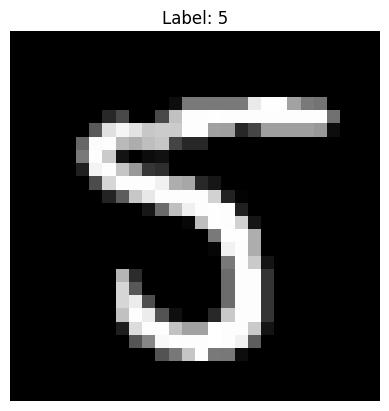

In [ ]:
#@title Retreive MNIST image
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the MNIST dataset
mnist = tf.keras.datasets.mnist
(_, _), (x_test, y_test) = mnist.load_data()

# Normalize the images to the range of 0 to 1
x_test = x_test / 255.0

# Select an image from the test dataset
index = 540  # Change this index to view different images
image = x_test[index]
label = y_test[index]

# Display the image and its label
plt.imshow(image, cmap='gray')
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()
